## Loading Libraries

In [1]:
from scipy.io import loadmat
from scipy import stats
import scipy
import h5py
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import math
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from IPython.display import display
from datetime import datetime
import scipy.stats as stats
from scipy.stats import ttest_ind
from itertools import combinations

## Function needs to be defined

In [2]:
def get_analysis_dir():
    """Returns the path to the wmDistort_analysis_code folder on the Desktop."""
    return os.path.join(os.path.expanduser("~"), "Desktop", "wmDistort_analysis_code")

# -------------------------------------------------------------
# Drawing Tilted Bar
# -------------------------------------------------------------

def generate_tilted_bar_image(angle, bar_length=1.0, bar_height=0.1, color='royalblue', dpi = 100):
    """
    Generates an image of a tilted bar at a specific angle and color.
    Saves it in a 'tilted_bar_images' folder on the Desktop and **overwrites** existing images.
    """
    # Get the Desktop directory and create a subfolder
    analysis_dir = get_analysis_dir()
    save_dir = os.path.join(analysis_dir, "tilted_bar_images")

    # Create the directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Define the filename (same name regardless of color, but content will be updated)
    filename = os.path.join(save_dir, f"{int(angle)}.png")

    # Generate figure and axis
    fig, ax = plt.subplots(figsize=(bar_length * 3, bar_length * 3), dpi = 300)
    
    # Create the bar as a rectangle
    bar = patches.Rectangle(
        (0, 0), bar_length, bar_height,
        angle=angle, color=color, edgecolor='none'
    )
    
    # Add the rectangle to the plot
    ax.add_patch(bar)
    ax.set_xlim(-bar_length, bar_length)
    ax.set_ylim(-bar_length, bar_length)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Save the image (overwrite if it exists)
    plt.savefig(filename, dpi=dpi, transparent=True, pad_inches=-0.08, bbox_inches='tight')
    plt.close()
    
    print(f"Image saved (overwritten if existed): {filename}")
    
# -------------------------------------------------------------
# Drawing Tilted Arrow
# -------------------------------------------------------------
def generate_tilted_arrow_image(angle, arrow_length=1.0, arrow_head_width=0.2, arrow_head_length=0.3, color='royalblue', dpi=100):
    """
    Generates an image of a tilted arrow at a specific angle and color.
    Saves it in a 'tilted_arrow_images' folder on the Desktop and **overwrites** existing images.
    """
    # Get the Desktop directory and create a subfolder
    analysis_dir = get_analysis_dir()
    save_dir = os.path.join(analysis_dir, "tilted_arrow_images")

    # Create the directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Define the filename (same name regardless of color, but content will be updated)
    filename = os.path.join(save_dir, f"{int(angle)}.png")

    # Generate figure and axis
    fig, ax = plt.subplots(figsize=(arrow_length * 3, arrow_length * 3), dpi=dpi)

    # Convert angle to radians for rotation
    theta = np.radians(angle)

    # Define arrow start and end points
    x_start, y_start = 0, 0  
    x_end = arrow_length * np.cos(theta)
    y_end = arrow_length * np.sin(theta)

    # Draw arrow
    ax.arrow(
        x_start, y_start, x_end, y_end, 
        head_width=arrow_head_width, head_length=arrow_head_length, 
        fc=color, ec=color, linewidth=8
    )

    # Set limits and remove ticks
    ax.set_xlim(-arrow_length*1.5, arrow_length*1.5)
    ax.set_ylim(-arrow_length*1.5, arrow_length*1.5)
    ax.set_xticks([])
    ax.set_yticks([])

    # Save the image (overwrite if it exists)
    plt.savefig(filename, dpi=dpi, transparent=True, pad_inches=-0.08, bbox_inches='tight')
    plt.close()

    print(f"Image saved (overwritten if existed): {filename}")
# generate_tilted_arrow_image(angle=45, arrow_length=1.0, arrow_head_width=0.2, arrow_head_length=0.3, color='royalblue')


In [4]:
# Define the distances_for_apertures dictionary
distances_for_apertures = {
    'square': [4.288717756774156, 5.483243101579638, 5.483243101579639, 4.288717756774156, 4.288717756774156, 5.483243101579639, 5.483243101579637, 4.288717756774156, 4.288717756774156, 5.483243101579638, 5.483243101579639, 4.288717756774156, 4.288717756774156, 5.483243101579639, 5.483243101579637, 4.288717756774156],
    'wide_rectangle': [7.1537177567741566, 4.825438135843182, 2.6182431015796386, 1.4237177567741561, 1.4237177567741561, 2.6182431015796386, 4.825438135843182, 7.1537177567741566, 7.1537177567741566, 4.825438135843182, 2.6182431015796386, 1.4237177567741561, 1.4237177567741561, 2.6182431015796386, 4.825438135843182, 7.1537177567741566],
    'tall_rectangle': [1.4237177567741561, 2.6182431015796377, 4.825438135843181, 7.1537177567741566, 7.1537177567741566, 4.825438135843181, 2.618243101579637, 1.4237177567741561, 1.4237177567741561, 2.6182431015796377, 4.825438135843181, 7.1537177567741566, 7.1537177567741566, 4.825438135843181, 2.618243101579637, 1.4237177567741561],
    'circle': [4.135, 4.135, 4.135, 4.135, 4.135, 4.135, 4.135, 4.135, 4.135, 4.135, 4.135, 4.135, 4.135, 4.135, 4.135, 4.135]
}

# Target angles list
target_angles_list = [11.25, 33.75, 56.25, 78.75, 101.25, 123.75, 146.25, 168.75,
                      -11.25, -33.75, -56.25, -78.75, -101.25, -123.75, -146.25, -168.75]

# ANOVA Analysis & Visualization

In [5]:
os.chdir('/Users/dannylim/Desktop/wmDistort_analysis_code/data')

# For selecting specific subjects
# selected_subjects = ["sub002","sub004","sub006","sub007","sub008"]  # Modify as needed
selected_subjects = ["sub002", "sub003", "sub004", "sub005", "sub006","sub007","sub008"]
# selected_subjects = ["sub998"]
mat_files = [f"{sub}_wmDistort_scored.mat" for sub in selected_subjects]

all_data = []
usability_stats = {}  # Dictionary to store usability for each participant

# Loop through each participant's mat files
for file in mat_files:
    # Load the .mat file
    md = scipy.io.loadmat(file)

    # Extract participant ID
    participant_id = file.split("_")[0]

    # Extract use_trial indices (valid trials)
    use_trial = md['ii_sess']['use_trial'][0][0].flatten()
    use_trial_idx = [i for i, val in enumerate(use_trial) if val == 1]  

    # Extract Final Saccade Error (FSE)
    fse = md['ii_sess']['f_sacc_err'][0][0]  
    total_datapoints = len(use_trial)
    clean_datapoints = len(use_trial_idx)
    data_usability = round((clean_datapoints / total_datapoints) * 100, 2)
    new_fse = fse[use_trial_idx]  

    # Store usability separately
    usability_stats[participant_id] = {
        "Usability (%)": data_usability,
        "Total Data Points": total_datapoints,
        "Clean Data Points": clean_datapoints
    }
            
    # Extract Condition values
    trial = md['ii_sess']['trialinfo']
    new_trial = [trial[0][0][i][0] for i in range(len(trial[0][0]))]
    conditions = np.array(new_trial)[use_trial_idx]  

    # Compute Target Angles
    targ_coords = [trial[0][0][i][1:3] for i in range(len(trial[0][0]))]  
    targ_angles = [round(math.degrees(math.atan2(y, x)), 2) for x, y in targ_coords]  
    angles_conditions = np.array(targ_angles)[use_trial_idx]  

    # Extract and process raw saccadic coordinates
    raw_saccadic_coords = md['ii_sess']['f_sacc_raw'][0][0]
    saccadic_coords = raw_saccadic_coords[use_trial_idx]
    saccadic_x, saccadic_y = saccadic_coords[:, 0], saccadic_coords[:, 1]

    # Extract target coordinates
    target_coords = np.array(targ_coords)
    target_x, target_y = target_coords[:, 0], target_coords[:, 1]
    target_x, target_y = target_x[use_trial_idx], target_y[use_trial_idx]

    # Extract and process pupil size
    pupil = np.array(md['ii_sess']['Pupil'])
    pupil = [arr[0] if isinstance(arr, (list, np.ndarray)) and len(arr) == 1 else arr for arr in pupil][0]
    flattened_pupil = []
    
    for i in range(len(pupil)):
        col_sum = sum(pupil[i][0][j][0] for j in range(len(pupil[i][0])))
        col_avg = round(col_sum / len(pupil[i][0]), 2)
        flattened_pupil.append(col_avg)
    
    pupil_np = np.array(flattened_pupil)[use_trial_idx]  # Keep only valid trials

    # Map conditions to aperture names
    aperture_map = {1: 'circle', 2: 'square', 3: 'wide_rectangle', 4: 'tall_rectangle'}
    
    # Add the distance for each trial
    distances = []
    for condition in conditions:
        aperture = aperture_map.get(condition, None)
        if aperture:
            distance = distances_for_apertures[aperture]
            # Map the distance to the corresponding target angle index
            angle_idx = target_angles_list.index(angles_conditions[conditions == condition][0])  # Find index of angle
            distances.append(distance[angle_idx])
        else:
            distances.append(None)  # If no aperture found

    # Create DataFrame for this subject
    df = pd.DataFrame({
        "Participant": participant_id,
        "Condition": conditions,
        "Target_Angle": angles_conditions,
        "Error": new_fse.flatten(),
        "Saccade_X": saccadic_x,
        "Saccade_Y": saccadic_y,
        "Target_X": target_x,
        "Target_Y": target_y,
        "Pupil_Average": pupil_np,
        "Distance": distances  # Add distance column
    })

    all_data.append(df)

# Concatenate all subjects
final_df = pd.concat(all_data, ignore_index=True)

# Save to CSV with new name
final_df.to_csv("all_subjects_data_with_pupil_and_distance.csv", index=False)

# Print summary
print(final_df.head())  
print(f"Total trials: {len(final_df)}")
print(final_df.groupby('Participant').size())  

# Print usability stats separately (only Usability %)
print("\nData Usability per Participant:")
for participant, stats in usability_stats.items():
    print(f"{participant}: {stats['Usability (%)']}%")

  Participant  Condition  Target_Angle     Error  Saccade_X  Saccade_Y  \
0      sub002        1.0       -101.25  1.537200  -1.004120  -6.413391   
1      sub002        4.0         11.25  2.408437   8.456148  -0.769220   
2      sub002        1.0        -11.25  1.465079   6.404022  -1.818291   
3      sub002        3.0        -56.25  2.381936   6.575305  -7.716440   
4      sub002        1.0        -33.75  1.450463   6.566087  -2.996631   

   Target_X  Target_Y  Pupil_Average  Distance  
0 -1.560723 -7.846282        3963.91  4.135000  
1  7.846282  1.560723        3536.96  1.423718  
2  7.846282 -1.560723        3687.49  4.135000  
3  4.444562 -6.651757        3262.80  2.618243  
4  6.651757 -4.444562        3743.04  4.135000  
Total trials: 2575
Participant
sub002    299
sub003    281
sub004    341
sub005    187
sub006    445
sub007    534
sub008    488
dtype: int64

Data Usability per Participant:
sub002: 77.86%
sub003: 48.78%
sub004: 81.97%
sub005: 29.22%
sub006: 69.53%
sub007: 87.

In [106]:
df

,Participant,Condition,Target_Angle,Error,Saccade_X,Saccade_Y,Target_X,Target_Y,Pupil_Average,Distance
0,sub008,4.00,-56.25,1.14,5.56,-6.88,4.44,-6.65,"2,747.83",4.83
1,sub008,2.00,101.25,2.23,-1.91,10.05,-1.56,7.85,"2,902.13",4.29
2,sub008,2.00,-146.25,0.79,-6.53,-5.22,-6.65,-4.44,"3,174.84",4.29
3,sub008,2.00,33.75,0.73,6.09,3.97,6.65,4.44,"2,842.01",4.29
4,sub008,1.00,101.25,0.00,-1.56,7.85,-1.56,7.85,"3,077.52",4.13
...,...,...,...,...,...,...,...,...,...,...
483,sub008,1.00,-168.75,0.96,-7.08,-2.14,-7.85,-1.56,"2,296.18",4.13
484,sub008,3.00,11.25,0.80,7.43,2.24,7.85,1.56,"2,583.08",1.42
485,sub008,2.00,33.75,0.00,6.65,4.44,6.65,4.44,"2,494.88",4.29
486,sub008,1.00,-78.75,0.83,1.26,-8.62,1.56,-7.85,"2,451.78",4.13


,Usability (%),Clean Data Points,Total Data Points
sub002,77.860000,299,384
sub003,48.780000,281,576
sub004,81.970000,341,416
sub005,29.220000,187,640
sub006,69.530000,445,640
sub007,87.830000,534,608
sub008,72.620000,488,672


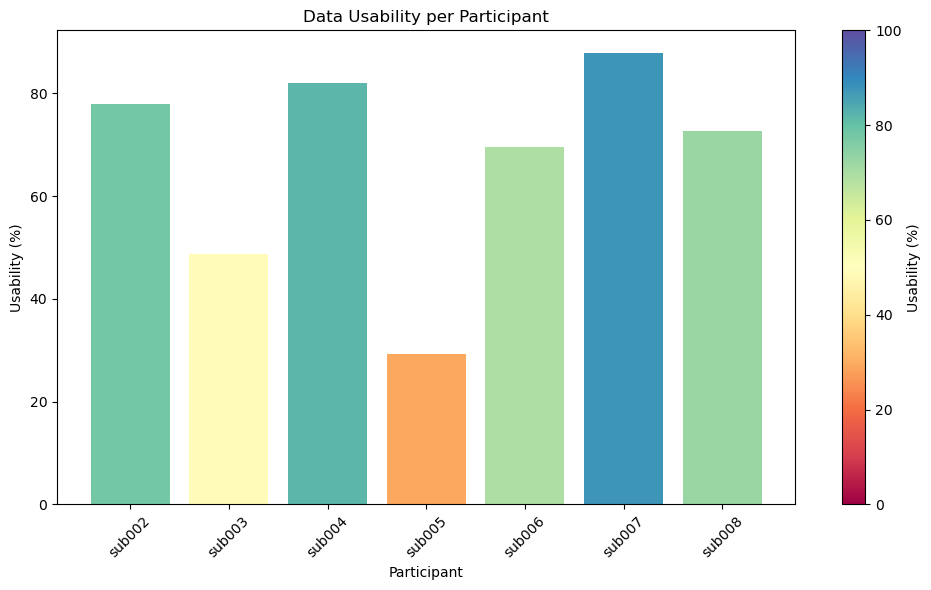

In [6]:
# Assuming 'usability_stats' is already defined with each participant's details
usability_df = pd.DataFrame.from_dict(usability_stats, orient='index', columns=["Usability (%)", "Clean Data Points", "Total Data Points"])

# Set up display formatting
pd.set_option('display.colheader_justify', 'center')  # Center column headers
pd.set_option('display.float_format', '{:,.2f}'.format)  # Format float numbers (optional)

def make_pretty(styler):
    styler.set_caption("Data Usability per Participant")
    
    # Apply background gradient only to "Usability (%)"
    styler.background_gradient(subset=["Usability (%)"], axis=0, vmin=0, vmax=100, cmap="Spectral")
    
    return styler

styled_df = usability_df.style.pipe(make_pretty)

# Display the styled DataFrame
display(styled_df)

# Assuming 'usability_df' is already defined

# Normalize 'Usability (%)' for color mapping
# norm = plt.Normalize(usability_df["Usability (%)"].min(), usability_df["Usability (%)"].max())
norm = plt.Normalize(0, 100)


# Create a custom color palette based on 'Usability (%)'
colors = plt.cm.Spectral(norm(usability_df["Usability (%)"]))  # Color map based on 'Usability (%)'

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(usability_df.index, usability_df["Usability (%)"], color=colors)

# Adding labels and title
plt.xlabel("Participant")
plt.ylabel("Usability (%)")
plt.title("Data Usability per Participant")
plt.xticks(rotation=45)

# Add color bar for reference
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
sm.set_array([])  # Required for the color bar
plt.colorbar(sm, label="Usability (%)")


# Display the plot
plt.tight_layout()

# # Create a unique filename using the current timestamp
# timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# filename = f"graph_{timestamp}.png"

# # Save the plot with the unique filename
# plt.savefig(filename)

plt.show()

In [109]:
# print(all_data)
print(df['Condition'].value_counts())

4.00    127
2.00    126
3.00    119
1.00    116
Name: Condition, dtype: int64


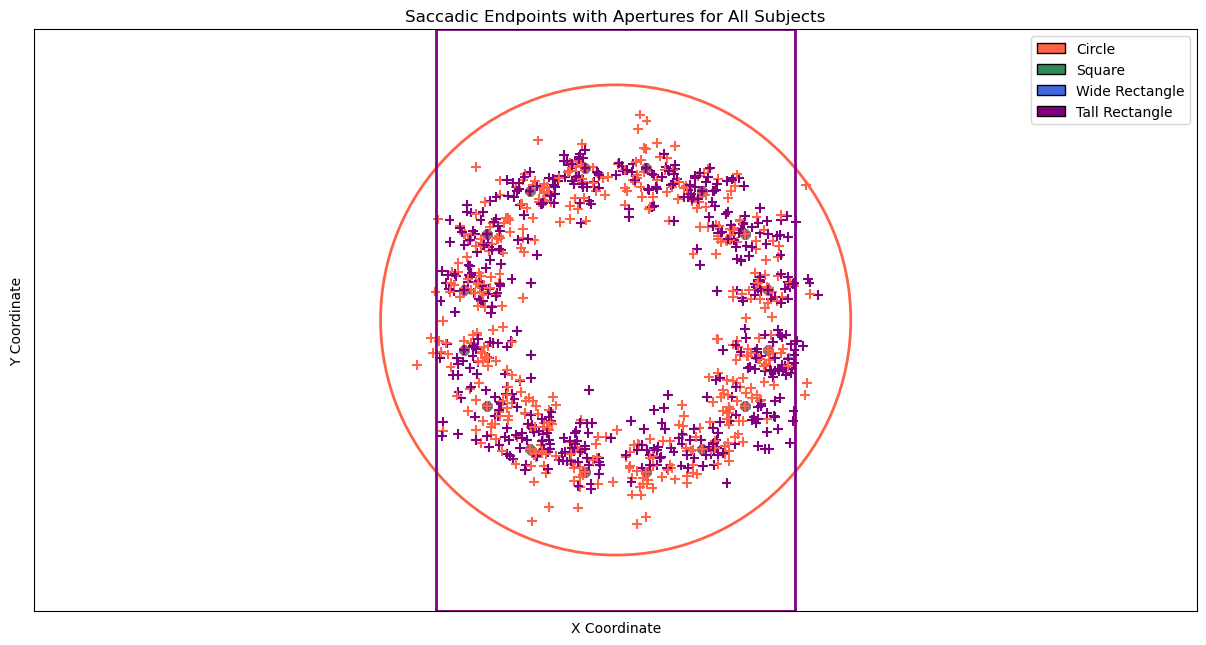

In [7]:
# Load the CSV file
file_path = "all_subjects_data_with_pupil_and_distance.csv"
df = pd.read_csv(file_path)

# -------------------------------------------------------------
# Simply Using All Subject Data
# -------------------------------------------------------------
saccadic_x = df["Saccade_X"].to_numpy()
saccadic_y = df["Saccade_Y"].to_numpy()
target_x = df["Target_X"].to_numpy()
target_y = df["Target_Y"].to_numpy()
categories = df["Condition"].to_numpy()
subject_ids = []
# -------------------------------------------------------------

# -------------------------------------------------------------
# Filtering data for specific subject
# -------------------------------------------------------------
# subject_ids = ["sub008"]  # List of subjects
# df_subject = df[df["Participant"].isin(subject_ids)]
# saccadic_x = df_subject["Saccade_X"].to_numpy()
# saccadic_y = df_subject["Saccade_Y"].to_numpy()
# target_x = df_subject["Target_X"].to_numpy()
# target_y = df_subject["Target_Y"].to_numpy()
# categories = df_subject["Condition"].to_numpy()
# -------------------------------------------------------------


# Define category colors corresponding to trial conditions
category_colors = {
    1: 'tomato',        # Circle
    2: 'seagreen',      # Square
    3: 'royalblue',     # Wide Rectangle
    4: 'purple'      # Tall Rectangle
}

# Aperture toggle options (True = display, False = hide)
toggle_apertures = {
    'circle': True,
    'square': False,
    'wide_rectangle': False,
    'tall_rectangle': True
}

# Aperture colors linked dynamically to category colors
aperture_colors = {
    'circle': category_colors[1],
    'square': category_colors[2],
    'wide_rectangle': category_colors[3],
    'tall_rectangle': category_colors[4]
}

# Filter data based on aperture toggle settings
filtered_data = []
for condition, x, y in zip(categories, saccadic_x, saccadic_y):
    if (condition == 1 and toggle_apertures['circle']) or \
       (condition == 2 and toggle_apertures['square']) or \
       (condition == 3 and toggle_apertures['wide_rectangle']) or \
       (condition == 4 and toggle_apertures['tall_rectangle']):
        filtered_data.append((x, y, condition))

filtered_data = np.array(filtered_data)
if len(filtered_data) > 0:
    saccadic_x, saccadic_y, categories = filtered_data[:, 0], filtered_data[:, 1], filtered_data[:, 2]
else:
    saccadic_x, saccadic_y, categories = np.array([]), np.array([]), np.array([])

# Map colors to filtered categories
point_colors = [category_colors[cat] for cat in categories]

# Define parameters
screen_height = 30
longest_side = screen_height  # Height of the monitor as the longest side
diameter_length = (screen_height + screen_height * 0.618) / 2  # For circular aperture

# Aperture dimensions
aperture_diameter = diameter_length
aperture_wide_rect = [screen_height * 0.618, screen_height]
aperture_tall_rect = [screen_height, screen_height * 0.618]
aperture_square = [diameter_length, diameter_length]

# Create figure
fig, ax = plt.subplots(figsize=(screen_height / 2, screen_height))
ax.set_xlim(-screen_height, screen_height)
ax.set_ylim(-screen_height/2, screen_height/2)

# Scatter plot for target and saccadic coordinates
ax.scatter(target_x, target_y, color='grey', marker='o', label='Target Locations')
if len(saccadic_x) > 0:
    ax.scatter(saccadic_x, saccadic_y, c=point_colors, s=50, marker='+', label='Saccadic Endpoints')

# Add apertures
if toggle_apertures['circle']:
    circle_aperture = patches.Circle((0, 0), radius=aperture_diameter / 2, linewidth=2, 
                                     edgecolor=aperture_colors['circle'], facecolor='none', linestyle='-')
    ax.add_patch(circle_aperture)

if toggle_apertures['square']:
    square_aperture = patches.Rectangle((-aperture_square[0] / 2, -aperture_square[1] / 2), 
                                        aperture_square[0], aperture_square[1], 
                                        linewidth=2, edgecolor=aperture_colors['square'], facecolor='none', linestyle='-')
    ax.add_patch(square_aperture)

if toggle_apertures['tall_rectangle']:
    wide_rectangle_aperture = patches.Rectangle((-aperture_wide_rect[0] / 2, -aperture_wide_rect[1] / 2), 
                                                aperture_wide_rect[0], aperture_wide_rect[1], 
                                                linewidth=2, edgecolor=aperture_colors['tall_rectangle'], facecolor='none', linestyle='-')
    ax.add_patch(wide_rectangle_aperture)

if toggle_apertures['wide_rectangle']:
    tall_rectangle_aperture = patches.Rectangle((-aperture_tall_rect[0] / 2, -aperture_tall_rect[1] / 2), 
                                                aperture_tall_rect[0], aperture_tall_rect[1], 
                                                linewidth=2, edgecolor=aperture_colors['wide_rectangle'], facecolor='none', linestyle='-')
    ax.add_patch(tall_rectangle_aperture)

# Configure plot appearance
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Check if subject_ids is defined and not empty
if not subject_ids:
    title = "Saccadic Endpoints with Apertures for All Subjects"
else:
    title = f"Saccadic Endpoints with Apertures for {', '.join(subject_ids)}"
    
ax.set_title(title)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.legend(
    handles=[
        patches.Patch(facecolor=aperture_colors['circle'], edgecolor='black', label='Circle'),
        patches.Patch(facecolor=aperture_colors['square'], edgecolor='black', label='Square'),
        patches.Patch(facecolor=aperture_colors['wide_rectangle'], edgecolor='black', label='Wide Rectangle'),
        patches.Patch(facecolor=aperture_colors['tall_rectangle'], edgecolor='black', label='Tall Rectangle')
    ],
    loc='upper right',
    fontsize=10
)

# Show plot
plt.show()

In [17]:

def plot_kde_from_gdf(point_gdf, ax, bandwidth=None, gridsize=1, cmap='Greys'):
    from scipy.stats import gaussian_kde
    """
    Draws a kernel density estimation (KDE) heatmap from a GeoDataFrame of Points.

    Parameters:
        point_gdf (GeoDataFrame): GeoDataFrame with Point geometries.
        bandwidth (float or None): Bandwidth for KDE. If None, it is automatically chosen.
        gridsize (int): Resolution of the KDE grid.
        cmap (str): Matplotlib colormap for heatmap.
    """
    if point_gdf.empty:
        raise ValueError("GeoDataFrame is empty.")
    if not all(point_gdf.geometry.geom_type == "Point"):
        raise ValueError("GeoDataFrame must contain only Point geometries.")

    # Extract x and y coordinates
    x = point_gdf.geometry.x
    y = point_gdf.geometry.y

    # Create a grid over the area
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    xgrid, ygrid = np.mgrid[xmin:xmax:gridsize*1j, ymin:ymax:gridsize*1j]
    coords = np.vstack([x, y])
    
    # Perform kernel density estimation
    kde = gaussian_kde(coords, bw_method=bandwidth)
    density = kde(np.vstack([xgrid.ravel(), ygrid.ravel()])).reshape(xgrid.shape)
    density[density<0.04] = None
    # Plot
    ax.imshow(
        np.rot90(density),
        extent=[xmin, xmax, ymin, ymax],
        cmap=cmap,
        alpha=0.5
    )
    #point_gdf.plot(ax=ax, markersize=5, color='black', alpha=0.5)


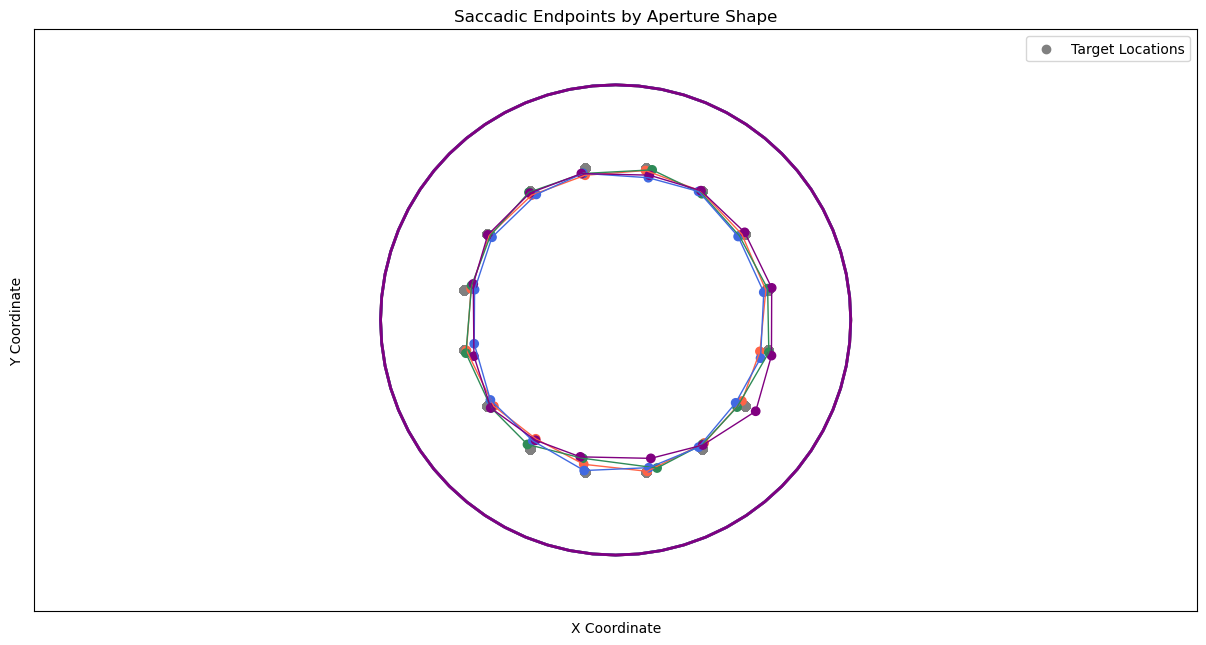

In [21]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
from shapely.geometry.polygon import Polygon
import numpy as np
from scipy.stats import gaussian_kde

# Load the CSV file
file_path = "all_subjects_data_with_pupil_and_distance.csv"
df = pd.read_csv(file_path)

# Define category colors
category_colors = {
    1: 'tomato',
    2: 'seagreen',
    3: 'royalblue',
    4: 'purple'
}

category_cmaps = {
    1: 'Reds',
    2: 'Greens',
    3: 'Blues',
    4: 'Purples'
}


# Toggle apertures
toggle_apertures = {
    'circle': True,
    'square': True,
    'wide_rectangle': True,
    'tall_rectangle': True
}

if_saccade_endpoint_plot = False
if_saccade_avgpoint_plot = True
if_saccade_avgpolygon_plot = True
if_saccade_density_plot = False

# Screen parameters
screen_height = 30
longest_side = screen_height
diameter_length = (screen_height + screen_height * 0.618) / 2

# Aperture dimensions
aperture_shapes = {}
if toggle_apertures['circle']:
    aperture_shapes[1] = Point(0, 0).buffer(diameter_length / 2)

if toggle_apertures['square']:
    w, h = diameter_length, diameter_length
    aperture_shapes[2] = Point(0, 0).buffer(diameter_length / 2)
#     aperture_shapes[2] = box(-w / 2, -h / 2, w / 2, h / 2)

if toggle_apertures['wide_rectangle']:
    w, h = screen_height, screen_height * 0.618
    aperture_shapes[3] = Point(0, 0).buffer(diameter_length / 2)
#     aperture_shapes[3] = box(-w / 2, -h / 2, w / 2, h / 2)

if toggle_apertures['tall_rectangle']:
    w, h = screen_height * 0.618, screen_height
    aperture_shapes[4] = Point(0, 0).buffer(diameter_length / 2)
#     aperture_shapes[4] = box(-w / 2, -h / 2, w / 2, h / 2)

# Convert to GeoDataFrame for saccadic endpoints
geometry = [Point(xy) for xy in zip(df["Saccade_X"], df["Saccade_Y"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Filter by aperture
filtered_gdfs = []
for cat, shape in aperture_shapes.items():
    filtered = gdf[(gdf["Condition"] == cat)]
    filtered_gdfs.append(filtered)

gdf_filtered = pd.concat(filtered_gdfs) if filtered_gdfs else gpd.GeoDataFrame(columns=gdf.columns)

# Plotting
fig, ax = plt.subplots(figsize=(screen_height / 2, screen_height))
ax.set_xlim(-screen_height, screen_height)
ax.set_ylim(-screen_height/2, screen_height/2)

# Target locations
target_points = gpd.GeoSeries([Point(x, y) for x, y in zip(df["Target_X"], df["Target_Y"])])
target_points.plot(ax=ax, color='grey', marker='o', label='Target Locations')

# Saccadic endpoints
if if_saccade_endpoint_plot: 
    if not gdf_filtered.empty:
        for cat in gdf_filtered["Condition"].unique():
            subset = gdf_filtered[gdf_filtered["Condition"] == cat]
            subset.plot(ax=ax, markersize=20, marker='+', color=category_colors[cat], 
                        label=f'Saccades (Condition {cat})')

# Apertures
for cat, shape in aperture_shapes.items():
    patch_gdf = gpd.GeoSeries([shape])
    patch_gdf.boundary.plot(ax=ax, linewidth=2, edgecolor=category_colors[cat], linestyle='-')

# Polygons
if if_saccade_avgpoint_plot | if_saccade_avgpolygon_plot:
    avg_df = gdf_filtered.groupby(['Condition', 'Target_Angle']).mean()
    avg_df = gpd.GeoDataFrame(avg_df, geometry=gpd.points_from_xy(avg_df.Saccade_X, avg_df.Saccade_Y))
    avg_df = avg_df.reset_index()
    avg_df.plot(ax=ax,color=avg_df.Condition.map(category_colors))

    if if_saccade_avgpolygon_plot:
        for cat, shape in aperture_shapes.items():
            con_df = avg_df.loc[avg_df.Condition==cat]
            con_poly = Polygon([x for x in con_df.geometry])
            gpd.GeoSeries([con_poly]).plot(ax=ax, facecolor="None", edgecolor=category_colors[cat])

if if_saccade_density_plot:
    for ind, subset in gdf_filtered.groupby(['Condition', 'Target_Angle']):
        ds = plot_kde_from_gdf(subset, ax, gridsize=100, bandwidth=1.2, 
                               cmap=category_cmaps[ind[0]])  # or vary colormap by condition

            
    
# Plot aesthetics
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_title("Saccadic Endpoints by Aperture Shape")
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc="upper right", fontsize=10)
plt.show()


In [215]:
# for _, subset in gdf_filtered.groupby(['Condition', 'Target_Angle']):
#     print(_)
#     fig, ax = plt.subplots(figsize=(screen_height / 2, screen_height))
#     plot_kde_on_ax(subset, ax)

In [141]:
# Distance to the aperture boundaries

# Aperture dimensions
aperture_shapes = {}
aperture_shapes[1] = Point(0, 0).buffer(diameter_length / 2)

w, h = diameter_length, diameter_length
aperture_shapes[2] = box(-w / 2, -h / 2, w / 2, h / 2)

w, h = screen_height, screen_height * 0.618
aperture_shapes[3] = box(-w / 2, -h / 2, w / 2, h / 2)

w, h = screen_height * 0.618, screen_height
aperture_shapes[4] = box(-w / 2, -h / 2, w / 2, h / 2)

# Convert to GeoDataFrame for saccadic endpoints
geometry = [Point(xy) for xy in zip(df["Target_X"], df["Target_Y"])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)



gdf['Distance'] = gdf.apply(lambda row: row.geometry.distance(aperture_shapes[row.Condition].boundary), axis=1)

In [114]:
gdf

,Participant,Condition,Target_Angle,Error,Saccade_X,Saccade_Y,Target_X,Target_Y,Pupil_Average,Distance,geometry
0,sub002,1.00,-101.25,1.54,-1.00,-6.41,-1.56,-7.85,"3,963.91",4.13,POINT (-1.56072 -7.84628)
1,sub002,4.00,11.25,2.41,8.46,-0.77,7.85,1.56,"3,536.96",1.42,POINT (7.84628 1.56072)
2,sub002,1.00,-11.25,1.47,6.40,-1.82,7.85,-1.56,"3,687.49",4.13,POINT (7.84628 -1.56072)
3,sub002,3.00,-56.25,2.38,6.58,-7.72,4.44,-6.65,"3,262.80",2.62,POINT (4.44456 -6.65176)
4,sub002,1.00,-33.75,1.45,6.57,-3.00,6.65,-4.44,"3,743.04",4.13,POINT (6.65176 -4.44456)
...,...,...,...,...,...,...,...,...,...,...,...
2570,sub008,1.00,-168.75,0.96,-7.08,-2.14,-7.85,-1.56,"2,296.18",4.13,POINT (-7.84628 -1.56072)
2571,sub008,3.00,11.25,0.80,7.43,2.24,7.85,1.56,"2,583.08",7.15,POINT (7.84628 1.56072)
2572,sub008,2.00,33.75,0.00,6.65,4.44,6.65,4.44,"2,494.88",5.48,POINT (6.65176 4.44456)
2573,sub008,1.00,-78.75,0.83,1.26,-8.62,1.56,-7.85,"2,451.78",4.13,POINT (1.56072 -7.84628)


ANOVA Results for Saccadic Error Across Conditions:
F-statistic: 0.820, p-value: 0.483


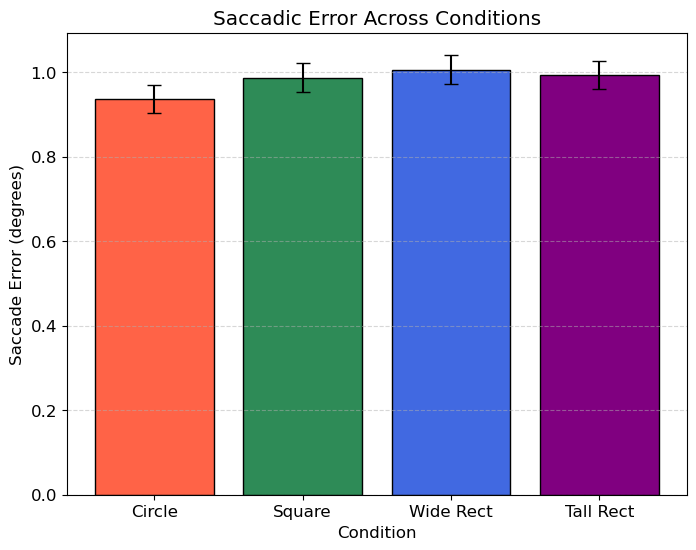


ANOVA Results for Pupil Size Across Conditions:
F-statistic: 0.6876, P-value: 0.5596


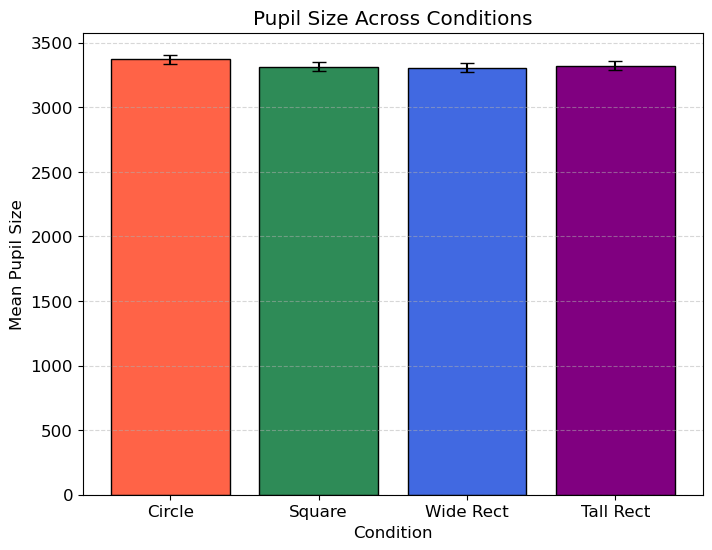

In [142]:
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

# Perform one-way ANOVA on 'Saccadic Error' across different 'Condition' levels
anova_error = stats.f_oneway(
    *[df[df["Condition"] == cond]["Error"] for cond in df["Condition"].unique()]
)

# Print ANOVA results for Error
print(f"ANOVA Results for Saccadic Error Across Conditions:")
print(f"F-statistic: {anova_error.statistic:.3f}, p-value: {anova_error.pvalue:.3f}")

# Compute mean and standard error for each condition for Error
condition_means_error = df.groupby("Condition")["Error"].mean()
condition_sems_error = df.groupby("Condition")["Error"].sem()

# Perform pairwise t-tests between conditions for Error
conditions = sorted(df["Condition"].unique())
p_values_error = {}
for cond1, cond2 in combinations(conditions, 2):
    stat, p = stats.ttest_ind(
        df[df["Condition"] == cond1]["Error"],
        df[df["Condition"] == cond2]["Error"],
        equal_var=False
    )
    p_values_error[(cond1, cond2)] = p

# Plot Saccadic Error results
plt.figure(figsize=(8, 6))
bars_error = plt.bar(
    condition_means_error.index,
    condition_means_error.values,
    yerr=condition_sems_error.values,
    capsize=5,
    color=[category_colors[c] for c in condition_means_error.index],
    edgecolor="black"
)

# Add significance markers for pairwise t-tests (Error)
y_max_error = max(condition_means_error + condition_sems_error)
offset_error = y_max_error * 0.05

for (cond1, cond2), p in p_values_error.items():
    if p < 0.05:  
        x1, x2 = cond1, cond2
        y = y_max_error + offset_error
        plt.plot([x1, x1, x2, x2], [y, y + offset_error, y + offset_error, y], color="black", lw=1)
        plt.text((x1 + x2) / 2, y + 1.5 * offset_error, "*" if p < 0.05 else "n.s.", ha="center", fontsize=12)

# Labels for Error plot
plt.xticks(conditions, labels=["Circle", "Square", "Wide Rect", "Tall Rect"])
plt.xlabel("Condition")
plt.ylabel("Saccade Error (degrees)")
plt.title("Saccadic Error Across Conditions")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


# Perform ANOVA for Pupil Size
anova_pupil = stats.f_oneway(
    df[df["Condition"] == 1]["Pupil_Average"],
    df[df["Condition"] == 2]["Pupil_Average"],
    df[df["Condition"] == 3]["Pupil_Average"],
    df[df["Condition"] == 4]["Pupil_Average"]
)

# Print ANOVA results for Pupil Size
print("\nANOVA Results for Pupil Size Across Conditions:")
print(f"F-statistic: {anova_pupil.statistic:.4f}, P-value: {anova_pupil.pvalue:.4f}")

# Compute means and standard errors for Pupil Size
condition_means_pupil = df.groupby("Condition")["Pupil_Average"].mean()
condition_sems_pupil = df.groupby("Condition")["Pupil_Average"].sem()

# Perform pairwise t-tests for Pupil Size
p_values_pupil = {}
for cond1, cond2 in combinations(conditions, 2):
    stat, p = stats.ttest_ind(
        df[df["Condition"] == cond1]["Pupil_Average"],
        df[df["Condition"] == cond2]["Pupil_Average"],
        equal_var=False
    )
    p_values_pupil[(cond1, cond2)] = p

# Plot Pupil Size results
plt.figure(figsize=(8, 6))
bars_pupil = plt.bar(
    condition_means_pupil.index,
    condition_means_pupil.values,
    yerr=condition_sems_pupil.values,
    capsize=5,
    color=[category_colors[c] for c in condition_means_pupil.index],
    edgecolor="black"
)

# Add significance markers for pairwise t-tests (Pupil Size)
y_max_pupil = max(condition_means_pupil + condition_sems_pupil)
offset_pupil = y_max_pupil * 0.05

for (cond1, cond2), p in p_values_pupil.items():
    if p < 0.05:  
        x1, x2 = cond1, cond2
        y = y_max_pupil + offset_pupil
        plt.plot([x1, x1, x2, x2], [y, y + offset_pupil, y + offset_pupil, y], color="black", lw=1)
        plt.text((x1 + x2) / 2, y + 1.5 * offset_pupil, "*" if p < 0.05 else "n.s.", ha="center", fontsize=12)

# Labels for Pupil Size plot
plt.xticks(conditions, labels=["Circle", "Square", "Wide Rect", "Tall Rect"])
plt.xlabel("Condition")
plt.ylabel("Mean Pupil Size")
plt.title("Pupil Size Across Conditions")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


ANOVA Results for Saccade Error (degrees) Across Conditions:
F-statistic: 0.820, p-value: 0.483


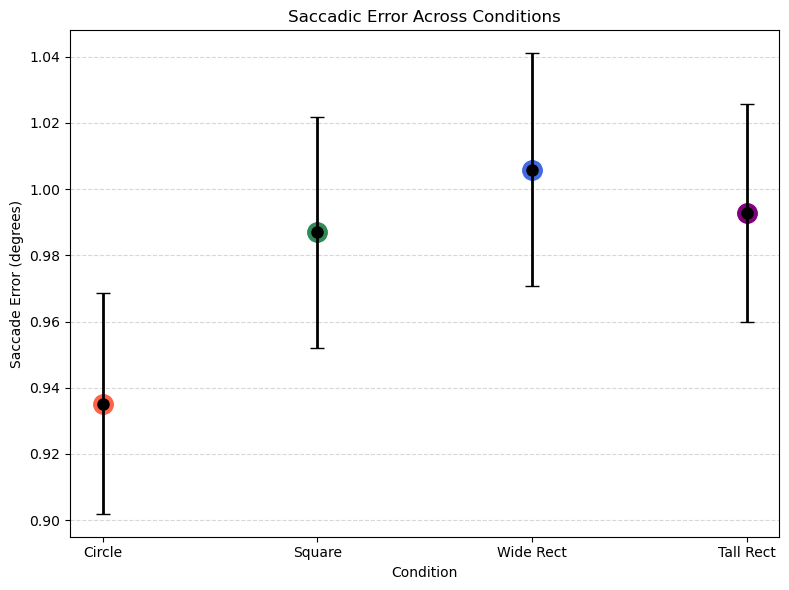


ANOVA Results for Mean Pupil Size Across Conditions:
F-statistic: 0.688, p-value: 0.560


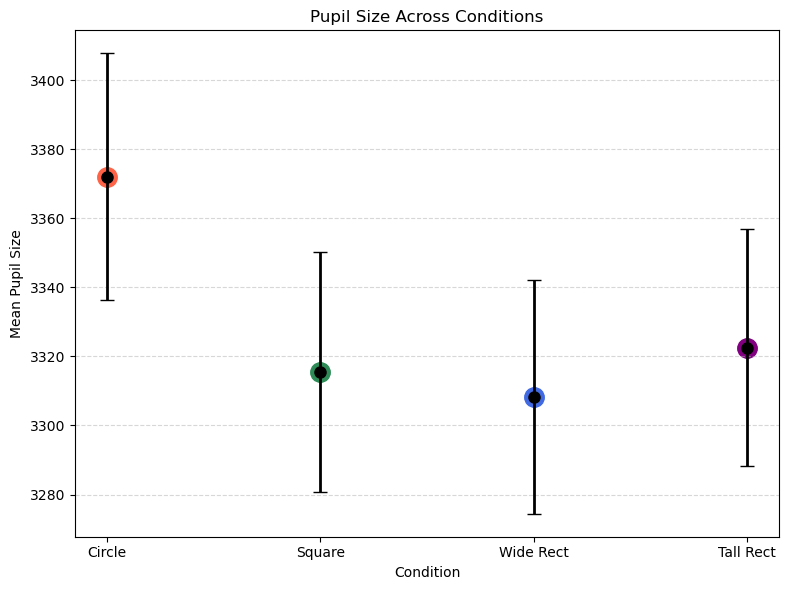

In [116]:
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

# === Assumes df and category_colors are already defined ===

conditions = sorted(df["Condition"].unique())
condition_labels = ["Circle", "Square", "Wide Rect", "Tall Rect"]

def plot_errorbar_metric(metric, ylabel, title):
    # ANOVA
    anova = stats.f_oneway(*[df[df["Condition"] == cond][metric] for cond in conditions])
    print(f"\nANOVA Results for {ylabel} Across Conditions:")
    print(f"F-statistic: {anova.statistic:.3f}, p-value: {anova.pvalue:.3f}")

    # Group statistics
    means = df.groupby("Condition")[metric].mean()
    sems = df.groupby("Condition")[metric].sem()

    # Pairwise t-tests
    p_values = {}
    for cond1, cond2 in combinations(conditions, 2):
        stat, p = stats.ttest_ind(
            df[df["Condition"] == cond1][metric],
            df[df["Condition"] == cond2][metric],
            equal_var=False
        )
        p_values[(cond1, cond2)] = p

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    x = np.arange(len(conditions))

    ax.errorbar(
        x, means.values, yerr=sems.values,
        fmt='o', capsize=5, color='black', ecolor='black', elinewidth=2, markersize=8
    )

    # Add colored dots behind black markers
    for i, cond in enumerate(conditions):
        ax.plot(x[i], means[cond], 'o', markersize=14, color=category_colors[cond], zorder=0)

    # Add significance markers
    y_max = max(means + sems)
    offset = y_max * 0.05
    line_height = offset * 1.5
    current_height = y_max + offset

    for (cond1, cond2), p in p_values.items():
        if p < 0.05:
            x1, x2 = conditions.index(cond1), conditions.index(cond2)
            ax.plot([x1, x1, x2, x2], [current_height, current_height + line_height, current_height + line_height, current_height], color='black')
            ax.text((x1 + x2) / 2, current_height + line_height * 1.1, "*", ha='center', fontsize=12)
            current_height += offset * 1.5

    # Aesthetics
    ax.set_xticks(x)
    ax.set_xticklabels(condition_labels)
    ax.set_xlabel("Condition")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# Plot Saccadic Error
plot_errorbar_metric("Error", "Saccade Error (degrees)", "Saccadic Error Across Conditions")

# Plot Pupil Size
plot_errorbar_metric("Pupil_Average", "Mean Pupil Size", "Pupil Size Across Conditions")


In [143]:
# Filter out NaN values in the error column and target angle column
error_values = df['Error'].dropna()
target_angles = df['Target_Angle'].dropna()

# Ensure the target angles are categorical (grouping by unique target angles)
unique_target_angles = np.unique(target_angles)

# Group the error values by target angle
grouped_error_values_by_angle = [error_values[target_angles == angle] for angle in unique_target_angles]

# Perform the ANOVA
f_statistic, p_value_target_angles = stats.f_oneway(*grouped_error_values_by_angle)

# Print out the ANOVA results
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value_target_angles}")

# Check if there is a significant difference (e.g., p < 0.05)
if p_value_target_angles < 0.05:
    print("There is a significant difference in error across target angles.")
else:
    print("No significant difference in error across target angles.")

# Perform one-way ANOVA
f_statistic, p_value_target_angles = stats.f_oneway(*grouped_error_values_by_angle)

# Print out the ANOVA results
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value_target_angles}")

# Check if there is a significant difference (e.g., p < 0.05)
if p_value_target_angles < 0.05:
    print("There is a significant difference in error across target angles.")
    
    # Perform Tukey's HSD post-hoc test to find which angles are different
    # Prepare data for Tukey's HSD test
    df_posthoc = pd.DataFrame({
        'Error': error_values,
        'Target_Angle': target_angles
    })
    
    # Tukey's HSD test
    tukey_results = pairwise_tukeyhsd(df_posthoc['Error'], df_posthoc['Target_Angle'], alpha=0.05)
    
    # Print the Tukey HSD results
    print("\nTukey's HSD Results:")
    print(tukey_results)
    
else:
    print("No significant difference in error across target angles.")

F-statistic: 2.890437141396252
P-value: 0.00015179233674668044
There is a significant difference in error across target angles.
F-statistic: 2.890437141396252
P-value: 0.00015179233674668044
There is a significant difference in error across target angles.

Tukey's HSD Results:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
-168.75 -146.25  -0.0323    1.0 -0.3766  0.3119  False
-168.75 -123.75   0.1194 0.9978 -0.2136  0.4525  False
-168.75 -101.25   0.0635    1.0 -0.2715  0.3985  False
-168.75  -78.75   0.0317    1.0 -0.3053  0.3686  False
-168.75  -56.25   0.0131    1.0 -0.3167  0.3429  False
-168.75  -33.75   0.0828    1.0 -0.2522  0.4177  False
-168.75  -11.25  -0.0405    1.0  -0.377  0.2959  False
-168.75   11.25  -0.3623 0.0206 -0.6988 -0.0259   True
-168.75   33.75  -0.0671    1.0 -0.3961  0.2618  False
-168.75   56.25  -0.1572 0.9712 -0.4974   0.183  False
-168.75

In [8]:
# Filter and print p-values less than 0.05 from Tukey's HSD test
significant_pairs = tukey_results.summary().data[1:]  # Skip header row
significant_p_values = [row for row in significant_pairs if row[3] < 0.05]  # p-value is in the 5th column

# Display the significant pairs and p-values
for pair in significant_p_values:
    print(f"Comparison: {pair[0]} vs {pair[1]}, p-value: {pair[3]}")

Comparison: -168.75 vs 11.25, p-value: 0.0408
Comparison: -123.75 vs 11.25, p-value: 0.0086
Comparison: -78.75 vs 11.25, p-value: 0.0275
Comparison: -33.75 vs 11.25, p-value: 0.0027


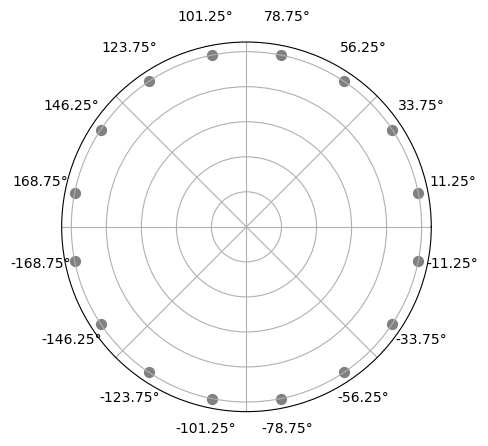

In [9]:
# Define the number of dots and angle intervals
num_dots = 16
interval = 360 / num_dots

# Create angle values with the condition that no value exceeds 180 degrees
angles = np.arange(11.25, 360, interval)

# Adjust angles to be within -180 to 180 range
adjusted_angles = np.where(angles > 180, angles - 360, angles)

# Create a plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(np.deg2rad(adjusted_angles), np.ones_like(adjusted_angles), color='grey', s=50)

# Annotate the angles
for angle in adjusted_angles:
    ax.annotate(f'{angle:.2f}°', 
                xy=(np.deg2rad(angle), 1), 
                xytext=(np.deg2rad(angle), 1.2),
                ha='center', fontsize=10)

# Display the plot
ax.set_yticklabels([])  # Hide the radial ticks
ax.set_xticklabels([])  # Hide the angular ticks
plt.show()

In [10]:
# Perform ANOVA for saccadic error
anova_error = stats.f_oneway(
    *[df[df["Condition"] == cond]["Error"] for cond in df["Condition"].unique()]
)
f_statistic_error = anova_error.statistic
p_value_error = anova_error.pvalue

# Perform ANOVA for pupil size
anova_pupil = stats.f_oneway(
    df[df["Condition"] == 1]["Pupil_Average"],
    df[df["Condition"] == 2]["Pupil_Average"],
    df[df["Condition"] == 3]["Pupil_Average"],
    df[df["Condition"] == 4]["Pupil_Average"]
)
f_statistic_pupil = anova_pupil.statistic
p_value_pupil = anova_pupil.pvalue

# Perform ANOVA for target angles
grouped_error_values_by_angle = [df[df["Target_Angle"] == angle]["Error"] for angle in df["Target_Angle"].unique()]
anova_angles = stats.f_oneway(*grouped_error_values_by_angle)
f_statistic_angles = anova_angles.statistic
p_value_angles = anova_angles.pvalue

# Create a table with the results
anova_results_table = pd.DataFrame({
    'Measure': ['Condition', 'Pupil Size', 'Target Angles'],
    'F-Statistic': [f_statistic_error, f_statistic_pupil, f_statistic_angles],
    'P-Value': [p_value_error, p_value_pupil, p_value_angles]
})

display(anova_results_table)

,Measure,F-Statistic,P-Value
0,Condition,0.201595,0.895328
1,Pupil Size,1.072718,0.359346
2,Target Angles,2.295243,0.003068


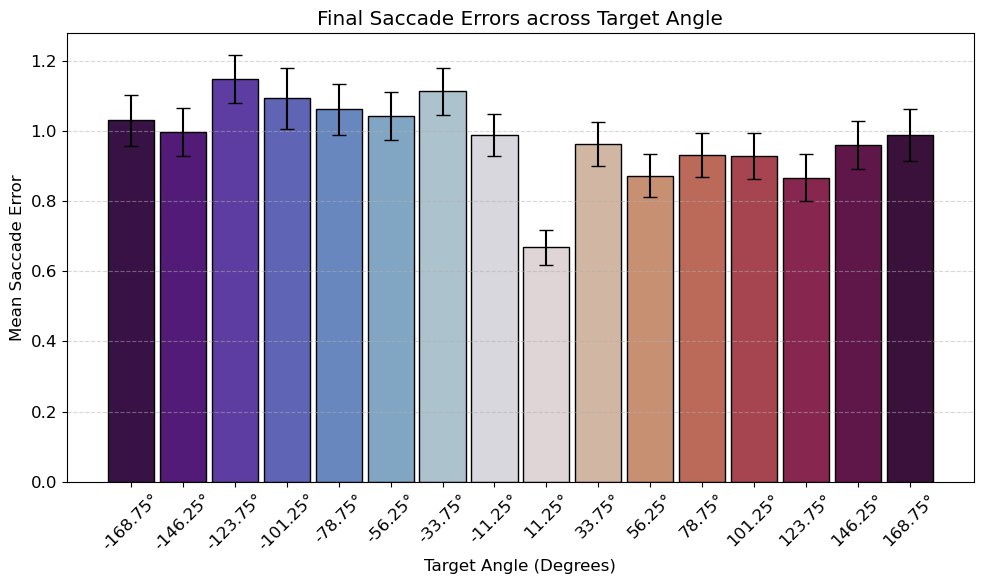

In [144]:
# Compute mean error per target angle
angle_means = df.groupby("Target_Angle")["Error"].mean()
angle_sems = df.groupby("Target_Angle")["Error"].sem()

# Normalize angles to a 0-1 range for cyclic colormap
unique_angles = sorted(df["Target_Angle"].unique())
colors = plt.cm.twilight_shifted((np.array(unique_angles) + 180) / 360)  # Cyclic twilight_shifted colormap

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(
    unique_angles, 
    angle_means, 
    yerr=angle_sems, 
    capsize=5, 
    color=colors, 
    edgecolor="black",
    width=20  # Adjust the width of the bars

)

# Labels and aesthetics
xticks_labels = [f"{angle}°" for angle in unique_angles]
plt.xticks(unique_angles, xticks_labels, rotation=45)  # Rotate x-axis labels for readability
plt.xlabel("Target Angle (Degrees)")
plt.ylabel("Mean Saccade Error")
plt.title("Final Saccade Errors across Target Angle")
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-168.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-146.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-123.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-101.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-78.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-56.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-33.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-11.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_cod

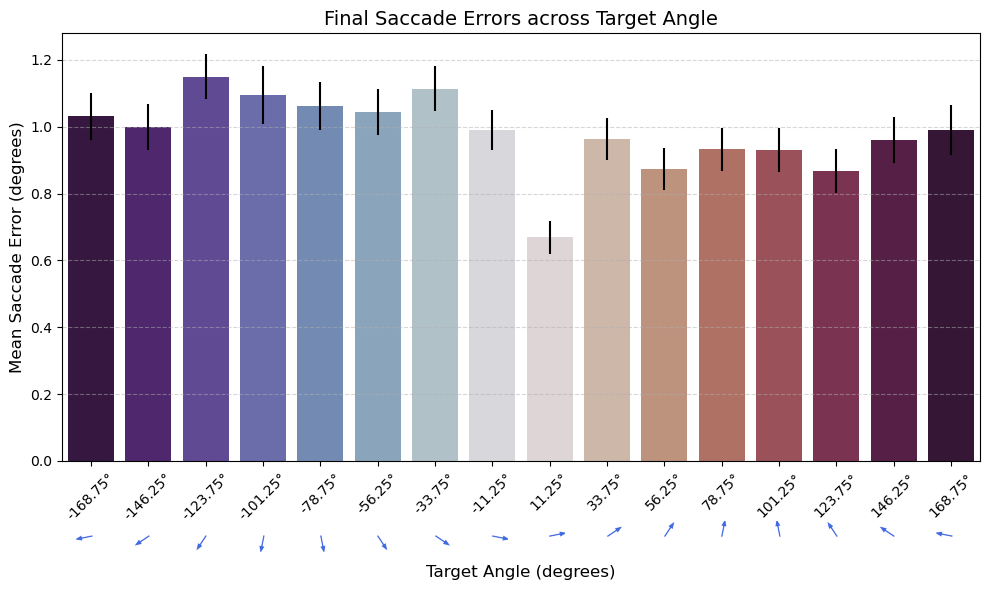

In [10]:
# Compute mean and standard error for each target angle
angle_means = df.groupby("Target_Angle")["Error"].mean()
angle_sems = df.groupby("Target_Angle")["Error"].sem()

# Normalize angles for cyclic colormap
unique_angles = sorted(df["Target_Angle"].unique())
colors = plt.cm.twilight_shifted((np.array(unique_angles) + 180) / 360)  # Cyclic colormap
# plot_color_gradients('Cyclic', ['twilight', 'twilight_shifted', 'hsv'])


# Generate the tilted arrow images for each unique angle
for angle in unique_angles:
    generate_tilted_arrow_image(angle=angle, arrow_length=1, arrow_head_width=0.3, arrow_head_length=0.4) # Generating actual arrow images
#     generate_tilted_bar_image(angle=angle) # Generating bar images


# Prepare data for plotting
data = pd.DataFrame({
    "Target_Angle": unique_angles,
    "Error": angle_means[unique_angles],
    "SEM": angle_sems[unique_angles]
})

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="Target_Angle", y="Error", yerr=angle_sems, capsize=5, data=data, palette=colors, ax=ax)

# Set custom xticks using generated images
xticks_labels = [f"{angle}°" for angle in unique_angles]
xticks_positions = np.arange(len(xticks_labels))
ax.set_xticks(xticks_positions)
ax.set_xticklabels(xticks_labels, rotation=45)

# Display the tilted arrow images at the x-ticks
image_directory = os.path.join(get_analysis_dir(), 'tilted_arrow_images')  # For using arrow images
# image_directory = os.path.join(get_analysis_dir(), 'tilted_bar_images') # For using bar images

for i, angle in enumerate(unique_angles):
    angle_int = int(angle)  # Convert to integer for filename
    image_path = os.path.join(image_directory, f'{angle_int}.png')

    if os.path.exists(image_path):
        img = plt.imread(image_path)  # Load image
        imagebox = OffsetImage(img, zoom=0.1, resample=True)  # Adjust zoom level as needed
        ab = AnnotationBbox(imagebox, (i, 0), frameon=False, xycoords='data', boxcoords="offset points", xybox=(0, -55))  # Position below axis
        ax.add_artist(ab)

# ax.set_ylim(ax.get_ylim()[0], np.max(data["Error"]) + 1)  # Adjust y-limits to fit images
ax.set_title('Final Saccade Errors across Target Angle', fontsize=14)
ax.set_xlabel('Target Angle (degrees)', fontsize=12, labelpad=30)
ax.set_ylabel('Mean Saccade Error (degrees)', fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

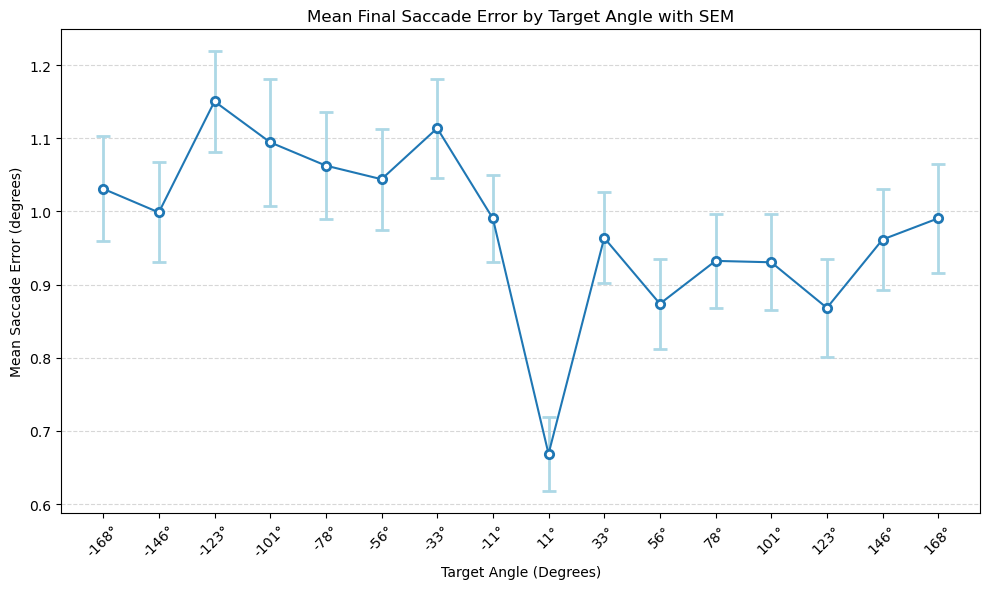

In [11]:
############################### TEST ###############################
############################### TEST ###############################
############################### TEST ###############################


import matplotlib.pyplot as plt
import numpy as np

# Compute mean and SEM per target angle
angle_stats = df.groupby("Target_Angle")["Error"].agg(['mean', 'sem']).reset_index()

# Normalize angles for cyclic colormap (shifted to center around 0°)
norm_angles = (angle_stats["Target_Angle"].values + 180) / 360
colors = plt.cm.twilight_shifted(norm_angles)

plt.figure(figsize=(10, 6))

# Plot mean error line with color corresponding to angle (optional: use single color if preferred)
plt.errorbar(
    angle_stats["Target_Angle"],
    angle_stats["mean"],
    yerr=angle_stats["sem"],
    fmt='-o',
    color='tab:blue',       # solid line color (change if you want gradient)
    ecolor='lightblue',     # error bar color
    elinewidth=2,
    capsize=5,
    markersize=6,
    markerfacecolor='white',
    markeredgewidth=2
)

plt.xticks(angle_stats["Target_Angle"], [f"{int(a)}°" for a in angle_stats["Target_Angle"]], rotation=45)
plt.xlabel("Target Angle (Degrees)")
plt.ylabel("Mean Saccade Error (degrees)")
plt.title("Mean Final Saccade Error by Target Angle with SEM")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


############################### TEST ###############################
############################### TEST ###############################
############################### TEST ###############################


Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-168.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-146.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-123.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-101.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-78.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-56.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-33.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-11.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_cod

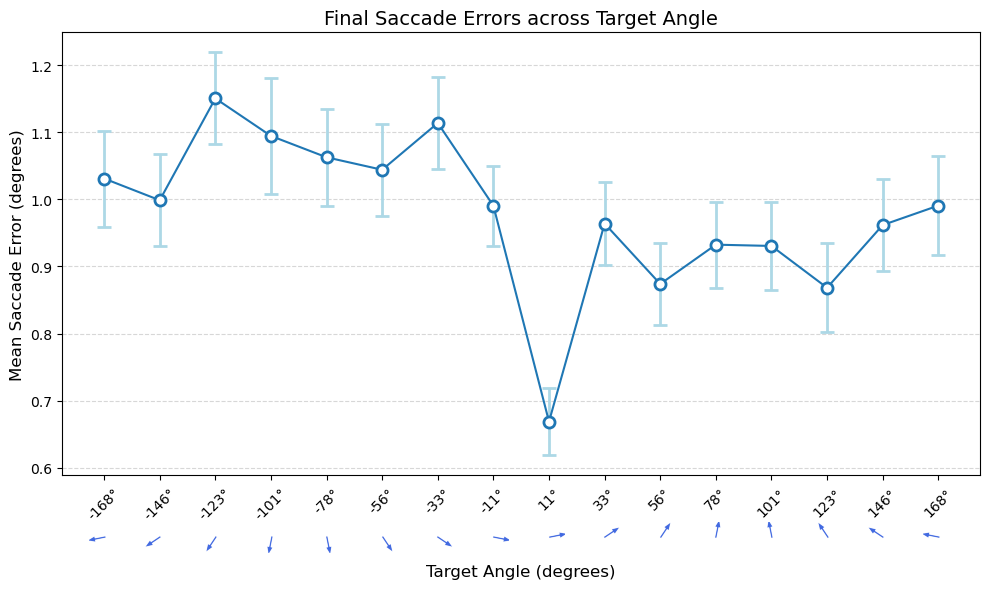

In [12]:
############################### TEST ###############################
############################### TEST ###############################
############################### TEST ###############################


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Assume df, unique_angles, colors, generate_tilted_arrow_image, get_analysis_dir() defined previously

# Compute mean and SEM for each target angle
angle_means = df.groupby("Target_Angle")["Error"].mean()
angle_sems = df.groupby("Target_Angle")["Error"].sem()

# Prepare data
data = pd.DataFrame({
    "Target_Angle": unique_angles,
    "Error": angle_means[unique_angles],
    "SEM": angle_sems[unique_angles]
})

# Generate arrow images if not already generated
for angle in unique_angles:
    generate_tilted_arrow_image(angle=angle, arrow_length=1, arrow_head_width=0.3, arrow_head_length=0.4)

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot error bars with line and markers
ax.errorbar(
    x=np.arange(len(data)),
    y=data["Error"],
    yerr=data["SEM"],
    fmt='-o',
    color='tab:blue',
    ecolor='lightblue',
    elinewidth=2,
    capsize=5,
    markersize=8,
    markerfacecolor='white',
    markeredgewidth=2,
)

# Set x-axis ticks and labels (degrees)
xticks_positions = np.arange(len(data))
xticks_labels = [f"{int(angle)}°" for angle in unique_angles]
ax.set_xticks(xticks_positions)
ax.set_xticklabels(xticks_labels, rotation=45)

# Add tilted arrow images below x-axis
image_directory = os.path.join(get_analysis_dir(), 'tilted_arrow_images')
for i, angle in enumerate(unique_angles):
    image_path = os.path.join(image_directory, f"{int(angle)}.png")
    if os.path.exists(image_path):
        img = plt.imread(image_path)
        imagebox = OffsetImage(img, zoom=0.1, resample=True)
        ab = AnnotationBbox(
            imagebox,
            (i, 0),
            frameon=False,
            #xycoords='data',
            xycoords=('data', 'axes fraction'),  # x = tick position; y = relative to axes (0 = bottom)
            boxcoords="offset points",
            xybox=(0, -45)  # vertical offset below x-axis labels
        )
        ax.add_artist(ab)

ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax)  # Adjust the bottom margin to see images below x-axis
ax.set_title('Final Saccade Errors across Target Angle', fontsize=14)
ax.set_xlabel('Target Angle (degrees)', fontsize=12, labelpad=30)
ax.set_ylabel('Mean Saccade Error (degrees)', fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


############################### TEST ###############################
############################### TEST ###############################
############################### TEST ###############################

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import ipywidgets as widgets
from IPython.display import display

# Compute mean and SEM for each target angle
angle_means = df.groupby("Target_Angle")["Error"].mean()
angle_sems = df.groupby("Target_Angle")["Error"].sem()

# Prepare data
data = pd.DataFrame({
    "Target_Angle": unique_angles,
    "Error": angle_means[unique_angles],
    "SEM": angle_sems[unique_angles]
})

# Configurations
condition_labels = {1: "Circle", 2: "Square", 3: "Wide Rect", 4: "Tall Rect"}
category_colors = {1: 'tomato', 2: 'seagreen', 3: 'royalblue', 4: 'purple'}
unique_angles = sorted(df["Target_Angle"].unique())
conditions = sorted(df["Condition"].unique())

# Compute means and SEMs
grouped = df.groupby(["Target_Angle", "Condition"])["Error"]
means = grouped.mean().unstack()
sems = grouped.sem().unstack()

# Generate tilted arrow images
for angle in unique_angles:
    generate_tilted_arrow_image(angle=angle, arrow_length=1, arrow_head_width=0.3, arrow_head_length=0.4)

# Interactive plotting function
def plot_selected_apertures(show_circle, show_square, show_wide, show_tall):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    toggles = {
        1: show_circle,
        2: show_square,
        3: show_wide,
        4: show_tall
    }
    
    for cond in conditions:
        if toggles[cond]:
            ax.errorbar(
                x=np.arange(len(unique_angles)),
                y=means[cond].values,
                yerr=sems[cond].values,
                fmt='-o',
                label=condition_labels[cond],
                color=category_colors[cond],
                ecolor=category_colors[cond],
                elinewidth=2,
                capsize=4,
                markersize=6,
                markerfacecolor='white',
                markeredgewidth=2
            )
    
    # X-axis setup
    xticks_positions = np.arange(len(unique_angles))
    xticks_labels = [f"{int(angle)}°" for angle in unique_angles]
    ax.set_xticks(xticks_positions)
    ax.set_xticklabels(xticks_labels, rotation=45)

    # Add arrow images
    image_directory = os.path.join(get_analysis_dir(), 'tilted_arrow_images')
    for i, angle in enumerate(unique_angles):
        image_path = os.path.join(image_directory, f"{int(angle)}.png")
        if os.path.exists(image_path):
            img = plt.imread(image_path)
            imagebox = OffsetImage(img, zoom=0.1, resample=True)
            ab = AnnotationBbox(
                imagebox,
                (i, 0),
                frameon=False,
                xycoords=('data', 'axes fraction'),
                boxcoords="offset points",
                xybox=(0, -45)
            )
            ax.add_artist(ab)
    
    ax.set_title('Final Saccade Errors across Target Angle by Aperture Shape', fontsize=14)
    ax.set_xlabel('Target Angle (degrees)', fontsize=12, labelpad=30)
    ax.set_ylabel('Mean Saccade Error (degrees)', fontsize=12)
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.legend(title="Aperture Condition")
    plt.tight_layout()
    plt.show()

# Create interactive widgets
widgets.interact(
    plot_selected_apertures,
    show_circle=widgets.Checkbox(value=True, description="Circle"),
    show_square=widgets.Checkbox(value=True, description="Square"),
    show_wide=widgets.Checkbox(value=True, description="Wide Rect"),
    show_tall=widgets.Checkbox(value=True, description="Tall Rect"),
)


Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-168.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-146.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-123.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-101.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-78.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-56.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-33.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-11.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_cod

interactive(children=(Checkbox(value=True, description='Circle'), Checkbox(value=True, description='Square'), …

<function __main__.plot_selected_apertures(show_circle, show_square, show_wide, show_tall)>

In [16]:
# Normalize angles to [0, 360)
unique_angles_raw = df["Target_Angle"].unique()
unique_angles_norm = np.mod(unique_angles_raw, 360)
unique_angles_norm_sorted = np.sort(unique_angles_norm)

# Map original angles to normalized ones for grouping
df["Target_Angle_Norm"] = np.mod(df["Target_Angle"], 360)

# Group by normalized angles instead of original
grouped = df.groupby(["Target_Angle_Norm", "Condition"])["Error"]
means = grouped.mean().unstack()
sems = grouped.sem().unstack()

# Append first angle for wraparound (closing the circle)
angle_radians = np.radians(np.append(unique_angles_norm_sorted, unique_angles_norm_sorted[0]))

def plot_selected_apertures(show_circle, show_square, show_wide, show_tall):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

    toggles = {
        1: show_circle,
        2: show_square,
        3: show_wide,
        4: show_tall
    }

    for cond in sorted(df["Condition"].unique()):
        if toggles[cond]:
            y = means[cond].loc[unique_angles_norm_sorted].tolist()
            yerr = sems[cond].loc[unique_angles_norm_sorted].tolist()

            y.append(y[0])
            yerr.append(yerr[0])

            ax.plot(angle_radians, y, '-o',
                    label=condition_labels[cond],
                    color=category_colors[cond],
                    markerfacecolor='white',
                    markeredgewidth=2)

            ax.fill_between(angle_radians,
                            np.array(y) - np.array(yerr),
                            np.array(y) + np.array(yerr),
                            color=category_colors[cond], alpha=0.2)

    # Dynamic radial limits based on plotted data
    all_y = []
    for cond in sorted(df["Condition"].unique()):
        if toggles[cond]:
            y_vals = means[cond].loc[unique_angles_norm_sorted].tolist()
            all_y.extend(y_vals)

#     if all_y:
#         data_min = min(all_y)
#         data_max = max(all_y)
#         data_range = data_max - data_min

#         padding = data_range * 0.1  # 10% padding for breathing room
#         rmin = data_min - padding
#         rmax = data_max + padding

#         # Avoid negative rmin if data_min is very small
#         if rmin < 0:
#             rmin = 0

#         ax.set_rlim(rmin, rmax)
#     else:
#         ax.set_rlim(0, 1)

    ax.set_theta_zero_location('E')  # zero degrees at right
    ax.set_theta_direction(1)        # counter-clockwise
    ax.set_xticks(np.radians(unique_angles_norm_sorted))
    ax.set_xticklabels([f"{int(a)}°" for a in unique_angles_norm_sorted], fontsize=10)
    ax.set_rlabel_position(135)
    ax.set_title("Final Saccade Error by Target Angle\n(Aperture Conditions)", fontsize=14, pad=20)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.15))
    plt.tight_layout()
    plt.show()
    
# Create interactive widget
widgets.interact(
    plot_selected_apertures,
    show_circle=widgets.Checkbox(value=True, description="Circle"),
    show_square=widgets.Checkbox(value=True, description="Square"),
    show_wide=widgets.Checkbox(value=True, description="Wide Rect"),
    show_tall=widgets.Checkbox(value=True, description="Tall Rect"),
)

interactive(children=(Checkbox(value=True, description='Circle'), Checkbox(value=True, description='Square'), …

<function __main__.plot_selected_apertures(show_circle, show_square, show_wide, show_tall)>

## For making GIF

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import imageio

# Setup
condition_labels = {1: "Circle", 2: "Square", 3: "Wide Rect", 4: "Tall Rect"}
category_colors = {1: 'tomato', 2: 'seagreen', 3: 'royalblue', 4: 'purple'}
unique_angles = sorted(df["Target_Angle"].unique())
conditions = sorted(df["Condition"].unique())

# Means & SEMs
grouped = df.groupby(["Target_Angle", "Condition"])["Error"]
means = grouped.mean().unstack()
sems = grouped.sem().unstack()

# Output frame directory
frame_dir = "gif_frames"
os.makedirs(frame_dir, exist_ok=True)

# Create arrow images
for angle in unique_angles:
    generate_tilted_arrow_image(angle=angle, arrow_length=1, arrow_head_width=0.3, arrow_head_length=0.4)

# Create and save a frame per condition toggle
filenames = []
for frame_idx, cond in enumerate(conditions, start=1):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot only current condition
    ax.errorbar(
        x=np.arange(len(unique_angles)),
        y=means[cond].values,
        yerr=sems[cond].values,
        fmt='-o',
        label=condition_labels[cond],
        color=category_colors[cond],
        ecolor=category_colors[cond],
        elinewidth=2,
        capsize=4,
        markersize=6,
        markerfacecolor='white',
        markeredgewidth=2
    )

    # Set x-axis
    xticks_positions = np.arange(len(unique_angles))
    xticks_labels = [f"{int(angle)}°" for angle in unique_angles]
    ax.set_xticks(xticks_positions)
    ax.set_xticklabels(xticks_labels, rotation=45)

    # Add arrows under x-axis
    image_directory = os.path.join(get_analysis_dir(), 'tilted_arrow_images')
    for i, angle in enumerate(unique_angles):
        image_path = os.path.join(image_directory, f"{int(angle)}.png")
        if os.path.exists(image_path):
            img = plt.imread(image_path)
            imagebox = OffsetImage(img, zoom=0.1, resample=True)
            ab = AnnotationBbox(imagebox, (i, 0), frameon=False,
                                xycoords=('data', 'axes fraction'),
                                boxcoords="offset points", xybox=(0, -45))
            ax.add_artist(ab)

    ax.set_title(f'Aperture: {condition_labels[cond]}', fontsize=14)
    ax.set_xlabel('Target Angle (degrees)', fontsize=12, labelpad=30)
    ax.set_ylabel('Mean Saccade Error (degrees)', fontsize=12)
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()

    # Save frame
    frame_path = os.path.join(frame_dir, f"frame_{frame_idx:02d}.png")
    plt.savefig(frame_path)
    filenames.append(frame_path)
    plt.close()

# Create GIF
gif_path = "aperture_toggle.gif"
with imageio.get_writer(gif_path, mode='I', duration=1.2) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"✅ GIF saved at: {os.path.abspath(gif_path)}")


Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-168.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-146.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-123.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-101.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-78.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-56.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-33.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_code/tilted_arrow_images/-11.png
Image saved (overwritten if existed): /Users/dannylim/Desktop/wmDistort_analysis_cod

/var/folders/64/03cwh6mj28s9zlb73ync90zh0000gn/T/ipykernel_9290/2384632487.py:83: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


✅ GIF saved at: /Users/dannylim/Desktop/wmDistort_analysis_code/data/aperture_toggle.gif


In [92]:
# Create directory for cumulative GIF frames
cumulative_dir = "gif_frames_cumulative"
os.makedirs(cumulative_dir, exist_ok=True)

cumulative_filenames = []

# Loop through 1 to 4 conditions, accumulating more lines
for step in range(1, len(conditions) + 1):
    fig, ax = plt.subplots(figsize=(10, 6))

    for cond in conditions[:step]:  # Only include first 'step' conditions
        ax.errorbar(
            x=np.arange(len(unique_angles)),
            y=means[cond].values,
            yerr=sems[cond].values,
            fmt='-o',
            label=condition_labels[cond],
            color=category_colors[cond],
            ecolor=category_colors[cond],
            elinewidth=2,
            capsize=4,
            markersize=6,
            markerfacecolor='white',
            markeredgewidth=2
        )

    # X-axis settings
    xticks_positions = np.arange(len(unique_angles))
    xticks_labels = [f"{int(angle)}°" for angle in unique_angles]
    ax.set_xticks(xticks_positions)
    ax.set_xticklabels(xticks_labels, rotation=45)

    # Add tilted arrow images under x-axis
    image_directory = os.path.join(get_analysis_dir(), 'tilted_arrow_images')
    for i, angle in enumerate(unique_angles):
        image_path = os.path.join(image_directory, f"{int(angle)}.png")
        if os.path.exists(image_path):
            img = plt.imread(image_path)
            imagebox = OffsetImage(img, zoom=0.1, resample=True)
            ab = AnnotationBbox(imagebox, (i, 0), frameon=False,
                                xycoords=('data', 'axes fraction'),
                                boxcoords="offset points", xybox=(0, -45))
            ax.add_artist(ab)

    # Title and labels
    active_labels = [condition_labels[c] for c in conditions[:step]]
    ax.set_title(" + ".join(active_labels), fontsize=14)
    ax.set_xlabel('Target Angle (degrees)', fontsize=12, labelpad=30)
    ax.set_ylabel('Mean Saccade Error (degrees)', fontsize=12)
    ax.legend(title="Aperture Condition")
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()

    # Save frame
    cum_frame_path = os.path.join(cumulative_dir, f"frame_{step:02d}.png")
    plt.savefig(cum_frame_path)
    cumulative_filenames.append(cum_frame_path)
    plt.close()

# Create cumulative GIF
cumulative_gif_path = "aperture_accumulate.gif"
with imageio.get_writer(cumulative_gif_path, mode='I', duration=1.2) as writer:
    for filename in cumulative_filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"✅ Cumulative GIF saved at: {os.path.abspath(cumulative_gif_path)}")


/var/folders/64/03cwh6mj28s9zlb73ync90zh0000gn/T/ipykernel_9290/3422780660.py:64: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


✅ Cumulative GIF saved at: /Users/dannylim/Desktop/wmDistort_analysis_code/data/aperture_accumulate.gif


In [152]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import imageio.v2 as imageio  # For saving GIF

# --- Configuration ---
condition_labels = {1: "Circle", 2: "Square", 3: "Wide Rect", 4: "Tall Rect"}
category_colors = {1: 'tomato', 2: 'seagreen', 3: 'royalblue', 4: 'purple'}

# --- Normalize angles and prepare data ---
df["Target_Angle_Norm"] = np.mod(df["Target_Angle"], 360)
unique_angles_norm_sorted = np.sort(df["Target_Angle_Norm"].unique())
angle_radians = np.radians(np.append(unique_angles_norm_sorted, unique_angles_norm_sorted[0]))

# --- Grouping stats ---
grouped = df.groupby(["Target_Angle_Norm", "Condition"])["Error"]
means = grouped.mean().unstack()
sems = grouped.sem().unstack()

# --- Output frame directory ---
frame_dir = "polar_gif_frames"
os.makedirs(frame_dir, exist_ok=True)
frame_paths = []

# --- Condition IDs for cumulative plotting ---
condition_order = [1, 2, 3, 4]

# --- Generate each frame ---
for i in range(1, len(condition_order) + 1):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
    active_conditions = condition_order[:i]
    all_y = []

    for cond in active_conditions:
        y = means[cond].loc[unique_angles_norm_sorted].tolist()
        yerr = sems[cond].loc[unique_angles_norm_sorted].tolist()
        y.append(y[0])
        yerr.append(yerr[0])
        all_y.extend(y)

        ax.plot(angle_radians, y, '-o',
                label=condition_labels[cond],
                color=category_colors[cond],
                markerfacecolor='white',
                markeredgewidth=2)

        ax.fill_between(angle_radians,
                        np.array(y) - np.array(yerr),
                        np.array(y) + np.array(yerr),
                        color=category_colors[cond], alpha=0.2)

    # Set radial limits for "spikiness"
#     if all_y:
#         y_min = min(all_y)
#         y_max = max(all_y)
#         padding = (y_max - y_min) * 0.1
#         rmin = max(0, y_min - padding)
#         rmax = y_max + padding
#         ax.set_rlim(rmin, rmax)
#     else:
#         ax.set_rlim(0, 1)

    # Axis formatting
    ax.set_theta_zero_location('E')
    ax.set_theta_direction(1)
    ax.set_xticks(np.radians(unique_angles_norm_sorted))
    ax.set_xticklabels([f"{int(a)}°" for a in unique_angles_norm_sorted], fontsize=10)
    ax.set_rlabel_position(135)
    ax.set_title("Final Saccade Error by Target Angle\n(Aperture Conditions)", fontsize=14, pad=20)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.15))

    # Save frame
    frame_path = os.path.join(frame_dir, f"frame_{i:02d}.png")
    plt.tight_layout()
    plt.savefig(frame_path, dpi=150)
    frame_paths.append(frame_path)
    plt.close()

# --- Compile GIF ---
gif_path = "cumulative_saccade_error.gif"
with imageio.get_writer(gif_path, mode='I', duration=1) as writer:
    for path in frame_paths:
        image = imageio.imread(path)
        writer.append_data(image)

print(f"✅ GIF saved to: {gif_path}")


✅ GIF saved to: cumulative_saccade_error.gif


# Statistical Modeling

## ANOVA

In [13]:
import scipy.stats as stats
import statsmodels.api as sm


df = pd.read_csv(file_path)

# Run two-way ANOVA with Condition
model = ols("Error ~ C(Condition)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA (common choice)

# Print ANOVA results
print(anova_table)

                   sum_sq      df         F    PR(>F)
C(Condition)     0.457739     3.0  0.201595  0.895328
Residual      2608.908514  3447.0       NaN       NaN


In [14]:
df = pd.read_csv(file_path)

# Run two-way ANOVA with Target Angle
model = ols("Error ~ C(Target_Angle)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA (common choice)

# Print ANOVA results
print(anova_table)

                      sum_sq      df         F    PR(>F)
C(Target_Angle)    25.893869    15.0  2.295243  0.003068
Residual         2583.472384  3435.0       NaN       NaN


In [15]:
df = pd.read_csv(file_path)

# Run two-way ANOVA with interaction
model = ols("Error ~ C(Condition) * C(Target_Angle)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA (common choice)

# Print ANOVA results
print(anova_table)

                                   sum_sq      df         F    PR(>F)
C(Condition)                     0.433890     3.0  0.192498  0.901556
C(Target_Angle)                 25.870020    15.0  2.295482  0.003066
C(Condition):C(Target_Angle)    38.278089    45.0  1.132155  0.253002
Residual                      2544.760405  3387.0       NaN       NaN


## GLM

In [16]:
from statsmodels.formula.api import glm

# Fit a GLM model with interaction
model = glm("Error ~ C(Condition)", data=df, family=sm.families.Gaussian()).fit()


# Print the summary
print(model.summary())
# print(model.pvalues)

# Extract the coefficients and p-values
coefficients = model.params
p_values = model.pvalues

# Filter the terms with p-value less than 0.05
significant_terms = p_values[p_values < 0.05]

# Extract the coefficients for the significant terms
significant_coefficients = coefficients[significant_terms.index]

# Combine both coefficients and p-values for significant terms
significant_results = pd.DataFrame({
    'Coefficient': significant_coefficients,
    'P-value': significant_terms
})

# Print the significant terms with their coefficients and p-values
print("Significant terms (p-value < 0.05):")
print(significant_results)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Error   No. Observations:                 3451
Model:                            GLM   Df Residuals:                     3447
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                         0.75686
Method:                          IRLS   Log-Likelihood:                -4414.1
Date:                Wed, 18 Jun 2025   Deviance:                       2608.9
Time:                        23:12:05   Pearson chi2:                 2.61e+03
No. Iterations:                     3   Pseudo R-squ. (CS):          0.0001759
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9602    

In [17]:
from statsmodels.formula.api import glm

# Fit a GLM model with interaction
model = glm("Error ~ C(Target_Angle)", data=df, family=sm.families.Gaussian()).fit()


# Print the summary
print(model.summary())
# print(model.pvalues)

# Extract the coefficients and p-values
coefficients = model.params
p_values = model.pvalues

# Filter the terms with p-value less than 0.05
significant_terms = p_values[p_values < 0.05]

# Extract the coefficients for the significant terms
significant_coefficients = coefficients[significant_terms.index]

# Combine both coefficients and p-values for significant terms
significant_results = pd.DataFrame({
    'Coefficient': significant_coefficients,
    'P-value': significant_terms
})

# Print the significant terms with their coefficients and p-values
print("Significant terms (p-value < 0.05):")
print(significant_results)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Error   No. Observations:                 3451
Model:                            GLM   Df Residuals:                     3435
Model Family:                Gaussian   Df Model:                           15
Link Function:               identity   Scale:                         0.75210
Method:                          IRLS   Log-Likelihood:                -4397.2
Date:                Wed, 18 Jun 2025   Deviance:                       2583.5
Time:                        23:12:08   Pearson chi2:                 2.58e+03
No. Iterations:                     3   Pseudo R-squ. (CS):           0.009937
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [18]:
from statsmodels.formula.api import glm

# Fit a GLM model with interaction
model = glm("Error ~ C(Condition) * C(Target_Angle)", data=df, family=sm.families.Gaussian()).fit()


# Print the summary
print(model.summary())
# print(model.pvalues)

# Extract the coefficients and p-values
coefficients = model.params
p_values = model.pvalues

# Filter the terms with p-value less than 0.05
significant_terms = p_values[p_values < 0.05]

# Extract the coefficients for the significant terms
significant_coefficients = coefficients[significant_terms.index]

# Combine both coefficients and p-values for significant terms
significant_results = pd.DataFrame({
    'Coefficient': significant_coefficients,
    'P-value': significant_terms
})

# Print the significant terms with their coefficients and p-values
print("Significant terms (p-value < 0.05):")
print(significant_results)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Error   No. Observations:                 3451
Model:                            GLM   Df Residuals:                     3387
Model Family:                Gaussian   Df Model:                           63
Link Function:               identity   Scale:                         0.75133
Method:                          IRLS   Log-Likelihood:                -4371.1
Date:                Wed, 18 Jun 2025   Deviance:                       2544.8
Time:                        23:12:14   Pearson chi2:                 2.54e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.02478
Covariance Type:            nonrobust                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [242]:
from statsmodels.formula.api import glm

# Fit a GLM model with interaction
model = glm("Error ~ C(Distance) * C(Target_Angle)", data=df, family=sm.families.Gaussian()).fit()


# Print the summary
print(model.summary())
# print(model.pvalues)

# Extract the coefficients and p-values
coefficients = model.params
p_values = model.pvalues

# Filter the terms with p-value less than 0.05
significant_terms = p_values[p_values < 0.05]

# Extract the coefficients for the significant terms
significant_coefficients = coefficients[significant_terms.index]

# Combine both coefficients and p-values for significant terms
significant_results = pd.DataFrame({
    'Coefficient': significant_coefficients,
    'P-value': significant_terms
})

# Print the significant terms with their coefficients and p-values
print("Significant terms (p-value < 0.05):")
print(significant_results)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Error   No. Observations:                 3451
Model:                            GLM   Df Residuals:                     3323
Model Family:                Gaussian   Df Model:                          127
Link Function:               identity   Scale:                         0.75144
Method:                          IRLS   Log-Likelihood:                -4338.5
Date:                Thu, 19 Jun 2025   Deviance:                       2497.0
Time:                        14:20:47   Pearson chi2:                 2.50e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.04307
Covariance Type:            nonrobust                                         
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------

In [19]:
import statsmodels.api as sm

# Fit the GLM model
model = sm.GLM(df['Error'], sm.add_constant(df[['Condition', 'Target_Angle']]), 
               family=sm.families.Gaussian()).fit()

# Compute McFadden's R^2 (pseudo R^2)
null_model = sm.GLM(df['Error'], sm.add_constant(df[['Condition', 'Target_Angle']].iloc[:, 0:1]),
                    family=sm.families.Gaussian()).fit()  # Null model (only intercept)
llf = model.llf  # Log-likelihood of the fitted model
llnull = null_model.llf  # Log-likelihood of the null model

# McFadden's R^2
pseudo_r2 = 1 - (llf / llnull)

# Print the pseudo R^2
print(f"McFadden's Pseudo R^2: {pseudo_r2:.4f}")


McFadden's Pseudo R^2: 0.0007


In [20]:
import statsmodels.api as sm
import numpy as np

# Fit the GLM model
model = sm.GLM(df['Error'], sm.add_constant(df[['Condition', 'Target_Angle']]), 
               family=sm.families.Gaussian()).fit()

# Compute log-likelihood values
llf = model.llf  # Log-likelihood of the fitted model
null_model = sm.GLM(df['Error'], sm.add_constant(df[['Condition', 'Target_Angle']].iloc[:, 0:1]),
                    family=sm.families.Gaussian()).fit()  # Null model (only intercept)
llnull = null_model.llf  # Log-likelihood of the null model

# McFadden's Pseudo R^2
pseudo_r2_mcfadden = 1 - (llf / llnull)

# Cox-Snell Pseudo R^2
cossnell_r2 = 1 - np.exp((2 * (llnull - llf)) / len(df))

# Nagelkerke Pseudo R^2
nagelkerke_r2 = cossnell_r2 / (1 - np.exp((2 * llnull) / len(df)))

# Print all pseudo R^2 values
print(f"McFadden's Pseudo R^2: {pseudo_r2_mcfadden:.4f}")
print(f"Cox-Snell Pseudo R^2: {cossnell_r2:.4f}")
print(f"Nagelkerke Pseudo R^2: {nagelkerke_r2:.4f}")


McFadden's Pseudo R^2: 0.0007
Cox-Snell Pseudo R^2: 0.0017
Nagelkerke Pseudo R^2: 0.0018


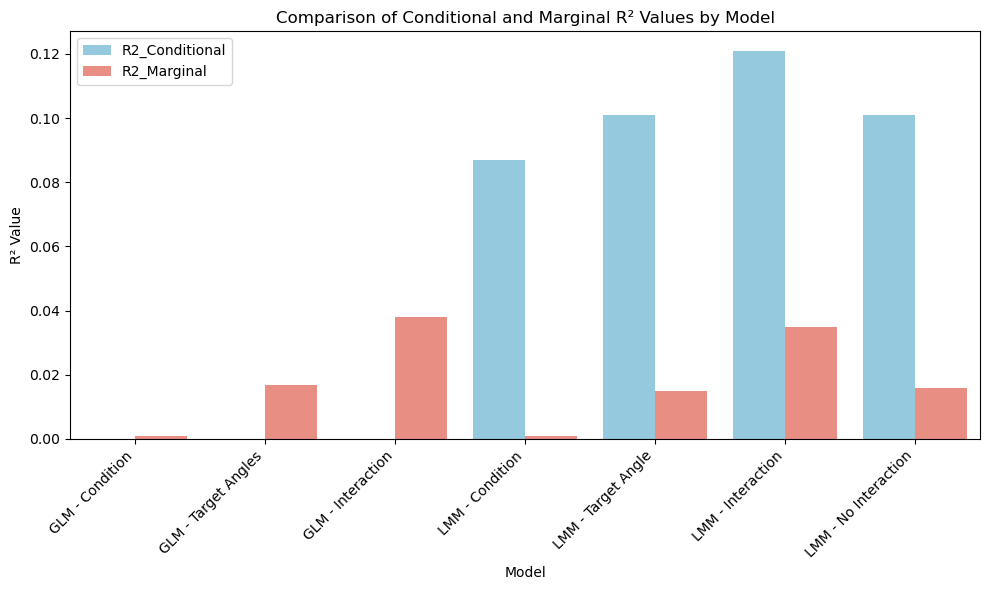

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example DataFrame
# data = {
#     "Model": ["GLM - Condition", "GLM - Target Angles", "GLM - Interaction",
#               "LMM - Condition", "LMM - Target Angle", "LMM - Interaction", "LMM - No Interaction", "LMM - Distance"],
#     "R2_Conditional": [None, None, None, 0.087, 0.101, 0.121, 0.101, 0.086],
#     "R2_Marginal": [0.0009560, 0.01672, 0.03788, 0.001, 0.015, 0.035, 0.016, 0.000001]
# }

data = {
    "Model": ["GLM - Condition", "GLM - Target Angles", "GLM - Interaction",
              "LMM - Condition", "LMM - Target Angle", "LMM - Interaction", "LMM - No Interaction"],
    "R2_Conditional": [None, None, None, 0.087, 0.101, 0.121, 0.101],
    "R2_Marginal": [0.0009560, 0.01672, 0.03788, 0.001, 0.015, 0.035, 0.016]
}

# Create the DataFrame
r2_df = pd.DataFrame(data)

# Reshape the DataFrame to long format
r2_df_long = pd.melt(r2_df, id_vars=["Model"], value_vars=["R2_Conditional", "R2_Marginal"],
                     var_name="R² Type", value_name="R² Value")

# Replace NaN values with 0 (or any other value as necessary)
r2_df_long['R² Value'].fillna(0, inplace=True)

# Define the color palette
color_palette = {"R2_Conditional": "skyblue", "R2_Marginal": "salmon"}

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="R² Value", hue="R² Type", data=r2_df_long, palette=color_palette)

# Customize the plot
plt.title("Comparison of Conditional and Marginal R² Values by Model")
plt.xlabel("Model")
plt.ylabel("R² Value")
plt.xticks(rotation=45, ha="right")
plt.legend(loc="upper left", bbox_to_anchor=(0, 1))  
plt.tight_layout()


# Show the plot
plt.show()

In [22]:
final_df

NameError: name 'final_df' is not defined

In [213]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
final_df = gdf
# final_df = final_df
# Ensure 'Participant' is treated as a categorical variable
final_df['Participant'] = final_df['Participant'].astype('category')
final_df['Condition'] = final_df['Condition'].astype('category')


# Fit the mixed model (this version avoids the C() function in the formula)
formula = 'Error ~ Distance'  # No need for C() on Participant here
# model = smf.mixedlm(formula, final_df, groups=final_df['Participant'])
model = sm.MixedLM.from_formula(
    formula, final_df, re_formula="Distance", groups=final_df["Participant"])
result = model.fit()


result.summary()
# # Get fixed effects predictions
# fixed_effects_preds = result.fittedvalues

# # Calculate Total Variance
# total_variance = np.var(final_df['Error'])

# # Calculate Residual Variance (Variance of the residuals)
# residual_variance = np.var(final_df['Error'] - fixed_effects_preds)

# # Calculate Marginal R² (for fixed effects)
# marginal_r2 = 1 - residual_variance / total_variance

# # Conditional R² is a bit more complex; we need to account for both fixed and random effects
# # This can be estimated by considering both fixed and random effect variances
# # Get the random effect variance
# random_effect_variance = result.cov_re.iloc[0, 0]

# # Calculate Conditional R² (for both fixed and random effects)
# conditional_r2 = 1 - (residual_variance / (residual_variance + random_effect_variance))

# # Print both R² values
# print(f"Marginal R²: {marginal_r2:.3f}")
# print(f"Conditional R²: {conditional_r2:.3f}")


/Users/dannylim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dannylim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/dannylim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dannylim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/dannylim/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed t

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   Error     
No. Observations:    3451      Method:               REML      
No. Groups:          4         Scale:                0.7514    
Min. group size:     853       Log-Likelihood:       -4419.2087
Max. group size:     871       Converged:            No        
Mean group size:     862.8                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.994    0.214  4.636 0.000  0.574  1.414
Distance             -0.008    0.064 -0.121 0.904 -0.134  0.118
Group Var             0.121                                    
Group x Distance Cov -0.031                                    
Distance Var          0.013                                    
===============================================================

"""

In [214]:
result

In [56]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

# Ensure 'Participant' is treated as a categorical variable
final_df['Participant'] = final_df['Participant'].astype('category')
final_df['Condition'] = final_df['Condition'].astype('category')
final_df['Target_Angle'] = final_df['Target_Angle'].astype('category')

# Fit the mixed model (adding Condition, Target_Angle, and their interaction)
formula = 'Error ~ Condition * Target_Angle'  # Interaction between Condition, and Target_Angle
model = smf.mixedlm(formula, final_df, groups=final_df['Participant'])
result = model.fit()

# Get fixed effects predictions
fixed_effects_preds = result.fittedvalues

# Calculate Total Variance
total_variance = np.var(final_df['Error'])

# Calculate Residual Variance (Variance of the residuals)
residual_variance = np.var(final_df['Error'] - fixed_effects_preds)

# Calculate Marginal R² (for fixed effects)
marginal_r2 = 1 - residual_variance / total_variance

# Conditional R² is a bit more complex; we need to account for both fixed and random effects
# This can be estimated by considering both fixed and random effect variances
# Get the random effect variance
random_effect_variance = result.cov_re.iloc[0, 0]

# Calculate Conditional R² (for both fixed and random effects)
conditional_r2 = 1 - (residual_variance / (residual_variance + random_effect_variance))

# Print both R² values
print(f"Marginal R²: {marginal_r2:.3f}")
print(f"Conditional R²: {conditional_r2:.3f}")


Marginal R²: 0.095
Conditional R²: 0.091


In [57]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

# Ensure 'Participant' is treated as a categorical variable
final_df['Participant'] = final_df['Participant'].astype('category')
final_df['Condition'] = final_df['Condition'].astype('category')
final_df['Target_Angle'] = final_df['Target_Angle'].astype('category')

# Fit the mixed model (adding Condition, Target_Angle, and their interaction)
formula = 'Error ~ Condition'  # Interaction between Distance, Condition, and Target_Angle
model = smf.mixedlm(formula, final_df, groups=final_df['Participant'], re_formula="~1")
result = model.fit()

# Get fixed effects predictions
fixed_effects_preds = result.fittedvalues

# Calculate Total Variance
total_variance = np.var(final_df['Error'])

# Calculate Residual Variance (Variance of the residuals)
residual_variance = np.var(final_df['Error'] - fixed_effects_preds)

# Calculate Marginal R² (for fixed effects)
marginal_r2 = 1 - residual_variance / total_variance

# Conditional R² is a bit more complex; we need to account for both fixed and random effects
# This can be estimated by considering both fixed and random effect variances
# Get the random effect variance
random_effect_variance = result.cov_re.iloc[0, 0]

# Calculate Conditional R² (for both fixed and random effects)
conditional_r2 = 1 - (residual_variance / (residual_variance + random_effect_variance))

# Print both R² values
print(f"Marginal R²: {marginal_r2:.3f}")
print(f"Conditional R²: {conditional_r2:.3f}")

Marginal R²: 0.027
Conditional R²: 0.031


In [55]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

# Ensure 'Participant' is treated as a categorical variable
final_df['Participant'] = final_df['Participant'].astype('category')
final_df['Condition'] = final_df['Condition'].astype('category')
final_df['Target_Angle'] = final_df['Target_Angle'].astype('category')

# Fit the mixed model (adding Condition, Target_Angle, and their interaction)
formula = 'Error ~ Target_Angle'  # Interaction between Distance, Condition, and Target_Angle
model = smf.mixedlm(formula, final_df, groups=final_df['Participant'], re_formula="~1")
result = model.fit()

# Get fixed effects predictions
fixed_effects_preds = result.fittedvalues

# Calculate Total Variance
total_variance = np.var(final_df['Error'])

# Calculate Residual Variance (Variance of the residuals)
residual_variance = np.var(final_df['Error'] - fixed_effects_preds)

# Calculate Marginal R² (for fixed effects)
marginal_r2 = 1 - residual_variance / total_variance

# Conditional R² is a bit more complex; we need to account for both fixed and random effects
# This can be estimated by considering both fixed and random effect variances
# Get the random effect variance
random_effect_variance = result.cov_re.iloc[0, 0]

# Calculate Conditional R² (for both fixed and random effects)
conditional_r2 = 1 - (residual_variance / (residual_variance + random_effect_variance))

# Print both R² values
print(f"Marginal R²: {marginal_r2:.3f}")
print(f"Conditional R²: {conditional_r2:.3f}")

Marginal R²: 0.073
Conditional R²: 0.087


In [ ]:
radius = 8
target_angles_list = [11.25, 33.75, 56.25, 78.75, 101.25, 123.75, 146.25, 168.75, 
                      -11.25, -33.75, -56.25, -78.75, -101.25, -123.75, -146.25, -168.75]

In [ ]:
# Given radius and target angles
radius = 8
target_angles_list = [11.25, 33.75, 56.25, 78.75, 101.25, 123.75, 146.25, 168.75, 
                      -11.25, -33.75, -56.25, -78.75, -101.25, -123.75, -146.25, -168.75]

# Convert angles to radians
angles_rad = np.radians(target_angles_list)

# Calculate x and y coordinates
x_coords = radius * np.cos(angles_rad)
y_coords = radius * np.sin(angles_rad)

# Combine x and y coordinates in a list
coords = list(zip(x_coords, y_coords))
coords
print(x_coords)
print(y_coords)

# 0 = right
# 1 = top
# 2 = left
# 3 = bottom
square_index = [0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 0, 0]
wide_rectangle = [0, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 0]
tall_rectangle = [0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 0, 0, 0]

In [ ]:
# For square, -11.25 degree distance
15-coords[target_angles_list.index(-11.25)][0] #since 0 is the x coordinates, 15 comes from the calculate boundaries function


In [ ]:
import numpy as np

# Define parameters
screen_height = 30
longest_side = screen_height  # Height of the monitor as the longest side
diameter_length = (screen_height + screen_height * 0.618) / 2  # For circular aperture

# Aperture dimensions
aperture_diameter = diameter_length
aperture_wide_rect = [screen_height, screen_height * 0.618]  # height, width
aperture_tall_rect = [screen_height * 0.618, screen_height]  # height, width
aperture_square = [diameter_length, diameter_length]

# Given radius and target angles
radius = 8
target_angles_list = [11.25, 33.75, 56.25, 78.75, 101.25, 123.75, 146.25, 168.75, 
                      -11.25, -33.75, -56.25, -78.75, -101.25, -123.75, -146.25, -168.75]

# Convert angles to radians
angles_rad = np.radians(target_angles_list)

# Calculate x and y coordinates
x_coords = radius * np.cos(angles_rad)
y_coords = radius * np.sin(angles_rad)

# Combine x and y coordinates in a list
coords = list(zip(x_coords, y_coords))

# Boundary values for each aperture shape (square, wide rectangle, tall rectangle, and circle)
# Square
square_right = aperture_square[0] / 2
square_left = -aperture_square[0] / 2
square_top = aperture_square[1] / 2
square_bottom = -aperture_square[1] / 2

# Wide Rectangle
wide_rect_right = aperture_wide_rect[0] / 2
wide_rect_left = -aperture_wide_rect[0] / 2
wide_rect_top = aperture_wide_rect[1] / 2
wide_rect_bottom = -aperture_wide_rect[1] / 2

# Tall Rectangle
tall_rect_right = aperture_tall_rect[0] / 2
tall_rect_left = -aperture_tall_rect[0] / 2
tall_rect_top = aperture_tall_rect[1] / 2
tall_rect_bottom = -aperture_tall_rect[1] / 2

# Circle - Coordinates would be (0, 0) at the center, radius = aperture_diameter / 2
circle_radius = aperture_diameter / 2
circle_right = circle_radius
circle_left = -circle_radius
circle_top = circle_radius
circle_bottom = -circle_radius

# Function to calculate the distance from the target point to the nearest boundary for each aperture
def calculate_distance(target_x, target_y, aperture_type):
    if aperture_type == "square":
        # Square - check left, right, top, bottom
        distances = {
            "right": abs(target_x - square_right),
            "left": abs(target_x - square_left),
            "top": abs(target_y - square_top),
            "bottom": abs(target_y - square_bottom)
        }
    elif aperture_type == "wide_rectangle":
        # Wide Rectangle - check left, right, top, bottom
        distances = {
            "right": abs(target_x - wide_rect_right),
            "left": abs(target_x - wide_rect_left),
            "top": abs(target_y - wide_rect_top),
            "bottom": abs(target_y - wide_rect_bottom)
        }
    elif aperture_type == "tall_rectangle":
        # Tall Rectangle - check left, right, top, bottom
        distances = {
            "right": abs(target_x - tall_rect_right),
            "left": abs(target_x - tall_rect_left),
            "top": abs(target_y - tall_rect_top),
            "bottom": abs(target_y - tall_rect_bottom)
        }
    elif aperture_type == "circle":
        # Circle - check distance from the radius
        distances = {
            "right": abs(target_x - circle_right),
            "left": abs(target_x - circle_left),
            "top": abs(target_y - circle_top),
            "bottom": abs(target_y - circle_bottom)
        }
    
    # Return the minimum distance
    return min(distances.values())

# Calculate distances for all target angles and apertures
distances_for_apertures = {
    "square": [],
    "wide_rectangle": [],
    "tall_rectangle": [],
    "circle": []
}

for target_angle, (target_x, target_y) in zip(target_angles_list, coords):
    distances_for_apertures["square"].append(calculate_distance(target_x, target_y, "square"))
    distances_for_apertures["wide_rectangle"].append(calculate_distance(target_x, target_y, "wide_rectangle"))
    distances_for_apertures["tall_rectangle"].append(calculate_distance(target_x, target_y, "tall_rectangle"))
    distances_for_apertures["circle"].append(calculate_distance(target_x, target_y, "circle"))

# Print the calculated distances
for aperture, distances in distances_for_apertures.items():
    print(f"Distances for {aperture} aperture:")
    print(distances)
    print()

Distances for square aperture with corresponding angles:
Angle: 11.25°, Distance: 4.288717756774156
Angle: 33.75°, Distance: 5.483243101579638
Angle: 56.25°, Distance: 5.483243101579639
Angle: 78.75°, Distance: 4.288717756774156
Angle: 101.25°, Distance: 4.288717756774156
Angle: 123.75°, Distance: 5.483243101579639
Angle: 146.25°, Distance: 5.483243101579637
Angle: 168.75°, Distance: 4.288717756774156
Angle: -11.25°, Distance: 4.288717756774156
Angle: -33.75°, Distance: 5.483243101579638
Angle: -56.25°, Distance: 5.483243101579639
Angle: -78.75°, Distance: 4.288717756774156
Angle: -101.25°, Distance: 4.288717756774156
Angle: -123.75°, Distance: 5.483243101579639
Angle: -146.25°, Distance: 5.483243101579637
Angle: -168.75°, Distance: 4.288717756774156

Distances for wide_rectangle aperture with corresponding angles:
Angle: 11.25°, Distance: 7.1537177567741566
Angle: 33.75°, Distance: 4.825438135843182
Angle: 56.25°, Distance: 2.6182431015796386
Angle: 78.75°, Distance: 1.423717756774156

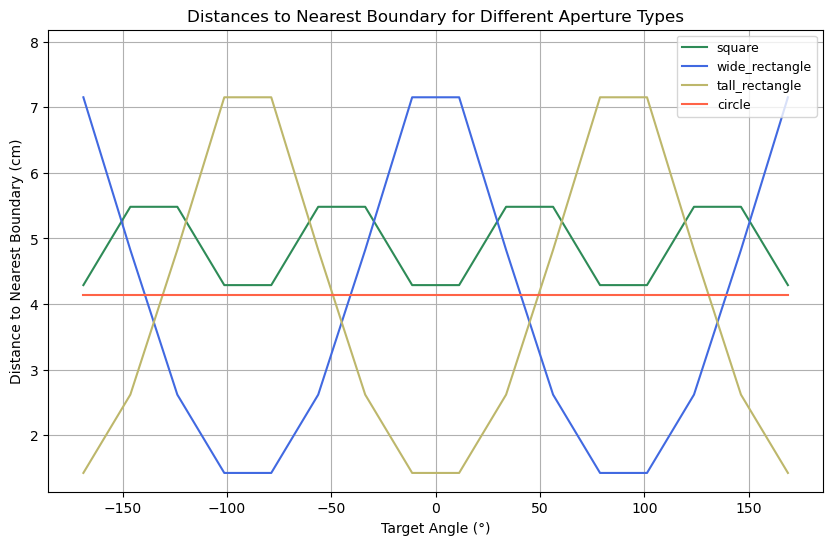

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
screen_height = 30
longest_side = screen_height  # Height of the monitor as the longest side
diameter_length = (screen_height + screen_height * 0.618) / 2  # For circular aperture

# Aperture dimensions
aperture_diameter = diameter_length
aperture_wide_rect = [screen_height, screen_height * 0.618]  # height, width
aperture_tall_rect = [screen_height * 0.618, screen_height]  # height, width
aperture_square = [diameter_length, diameter_length]

# Given radius and target angles
radius = 8
target_angles_list = [11.25, 33.75, 56.25, 78.75, 101.25, 123.75, 146.25, 168.75, 
                      -11.25, -33.75, -56.25, -78.75, -101.25, -123.75, -146.25, -168.75]

# Convert angles to radians
angles_rad = np.radians(target_angles_list)

# Calculate x and y coordinates
x_coords = radius * np.cos(angles_rad)
y_coords = radius * np.sin(angles_rad)

# Combine x and y coordinates in a list
coords = list(zip(x_coords, y_coords))

# Boundary values for each aperture shape (square, wide rectangle, tall rectangle, and circle)
# Square
square_right = aperture_square[0] / 2
square_left = -aperture_square[0] / 2
square_top = aperture_square[1] / 2
square_bottom = -aperture_square[1] / 2

# Wide Rectangle
wide_rect_right = aperture_wide_rect[0] / 2
wide_rect_left = -aperture_wide_rect[0] / 2
wide_rect_top = aperture_wide_rect[1] / 2
wide_rect_bottom = -aperture_wide_rect[1] / 2

# Tall Rectangle
tall_rect_right = aperture_tall_rect[0] / 2
tall_rect_left = -aperture_tall_rect[0] / 2
tall_rect_top = aperture_tall_rect[1] / 2
tall_rect_bottom = -aperture_tall_rect[1] / 2

# Circle - Coordinates would be (0, 0) at the center, radius = aperture_diameter / 2
circle_radius = aperture_diameter / 2
circle_right = circle_radius
circle_left = -circle_radius
circle_top = circle_radius
circle_bottom = -circle_radius

# Function to calculate the distance from the target point to the nearest boundary for each aperture
def calculate_distance(target_x, target_y, aperture_type):
    if aperture_type == "square":
        # Square - check left, right, top, bottom
        distances = {
            "right": abs(target_x - square_right),
            "left": abs(target_x - square_left),
            "top": abs(target_y - square_top),
            "bottom": abs(target_y - square_bottom)
        }
    elif aperture_type == "wide_rectangle":
        # Wide Rectangle - check left, right, top, bottom
        distances = {
            "right": abs(target_x - wide_rect_right),
            "left": abs(target_x - wide_rect_left),
            "top": abs(target_y - wide_rect_top),
            "bottom": abs(target_y - wide_rect_bottom)
        }
    elif aperture_type == "tall_rectangle":
        # Tall Rectangle - check left, right, top, bottom
        distances = {
            "right": abs(target_x - tall_rect_right),
            "left": abs(target_x - tall_rect_left),
            "top": abs(target_y - tall_rect_top),
            "bottom": abs(target_y - tall_rect_bottom)
        }
    elif aperture_type == "circle":
        # Circle - check distance from the radius
        distances = {
            "right": abs(diameter_length/2-8),
            "left": abs(diameter_length/2-8),
            "top": abs(diameter_length/2-8),
            "bottom": abs(diameter_length/2-8)
        }
    
    # Return the minimum distance
    return min(distances.values())

# Calculate distances for all target angles and apertures
distances_for_apertures = {
    "square": [],
    "wide_rectangle": [],
    "tall_rectangle": [],
    "circle": []
}

# Store the distances with angles for each aperture
distances_with_angles = {
    "square": [],
    "wide_rectangle": [],
    "tall_rectangle": [],
    "circle": []
}

for target_angle, (target_x, target_y) in zip(target_angles_list, coords):
    square_distance = calculate_distance(target_x, target_y, "square")
    wide_rect_distance = calculate_distance(target_x, target_y, "wide_rectangle")
    tall_rect_distance = calculate_distance(target_x, target_y, "tall_rectangle")
    circle_distance = calculate_distance(target_x, target_y, "circle")
    
    distances_for_apertures["square"].append(square_distance)
    distances_for_apertures["wide_rectangle"].append(wide_rect_distance)
    distances_for_apertures["tall_rectangle"].append(tall_rect_distance)
    distances_for_apertures["circle"].append(circle_distance)

    # Storing distances with corresponding angles
    distances_with_angles["square"].append((target_angle, square_distance))
    distances_with_angles["wide_rectangle"].append((target_angle, wide_rect_distance))
    distances_with_angles["tall_rectangle"].append((target_angle, tall_rect_distance))
    distances_with_angles["circle"].append((target_angle, circle_distance))

# Print the distances with angles for each aperture
for aperture, distances in distances_with_angles.items():
    print(f"Distances for {aperture} aperture with corresponding angles:")
    for angle, distance in distances:
        print(f"Angle: {angle}°, Distance: {distance}")
    print()

# Sorting angles and corresponding distances
sorted_indices = np.argsort(target_angles_list)
sorted_angles = np.array(target_angles_list)[sorted_indices]

# Define category colors corresponding to trial conditions
category_colors = {
    1: 'tomato',        # Circle
    2: 'seagreen',      # Square
    3: 'royalblue',     # Wide Rectangle
    4: 'darkkhaki'      # Tall Rectangle
}

# Aperture colors linked dynamically to category colors
aperture_colors = {
    'circle': category_colors[1],
    'square': category_colors[2],
    'wide_rectangle': category_colors[3],
    'tall_rectangle': category_colors[4]
}

# Plot the distances for each aperture type with its corresponding color
plt.figure(figsize=(10, 6))
for aperture, distances in distances_for_apertures.items():
    sorted_distances = np.array(distances)[sorted_indices]  # Sort distances accordingly
    # Use the appropriate color for each aperture
    plt.plot(sorted_angles, sorted_distances, label=f"{aperture}", color=aperture_colors[aperture])

plt.xlabel("Target Angle (°)")
plt.ylabel("Distance to Nearest Boundary (cm)")
plt.title("Distances to Nearest Boundary for Different Aperture Types")
y_min, y_max = plt.ylim()
plt.ylim(y_min, y_max * 1.1)
plt.legend(fontsize=9)  # Adjust the fontsize of the legend
plt.grid(True)
plt.show()


In [ ]:
distances_for_apertures

In [ ]:
plt.figure(figsize=(10, 6))
for aperture, distances in distances_for_apertures.items():
    plt.scatter(target_angles_list, distances, label=f"{aperture} aperture")

plt.xlabel("Target Angle (°)")
plt.ylabel("Distance to Nearest Boundary")
plt.title("Debugging: Scatter Plot of Distances")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
all_data

# Back Up

In [ ]:
os.chdir('/Users/dannylim/Desktop/wmDistort_analysis_code/data')

# For selecting specific subjects
selected_subjects = ["sub002","sub003","sub004","sub005","sub006","sub007","sub008"]  # Modify as needed
# selected_subjects = ["sub002"]
mat_files = [f"{sub}_wmDistort_scored.mat" for sub in selected_subjects]

all_data = []
usability_stats = {}  # Dictionary to store usability for each participant

for file in mat_files:
    # Load the .mat file
    md = scipy.io.loadmat(file)

    # Extract participant ID
    participant_id = file.split("_")[0]

    # Extract use_trial indices (valid trials)
    use_trial = md['ii_sess']['use_trial'][0][0].flatten()
    use_trial_idx = [i for i, val in enumerate(use_trial) if val == 1]  

    # Extract Final Saccade Error (FSE)
    fse = md['ii_sess']['f_sacc_err'][0][0]  
    total_datapoints = len(use_trial)
    clean_datapoints = len(use_trial_idx)
    data_usability = round((clean_datapoints / total_datapoints) * 100, 2)
    new_fse = fse[use_trial_idx]  

    # Store usability separately
    usability_stats[participant_id] = {
        "Usability (%)": data_usability,
        "Total Data Points": total_datapoints,
        "Clean Data Points": clean_datapoints
    }
            
    # Extract Condition values
    trial = md['ii_sess']['trialinfo']
    new_trial = [trial[0][0][i][0] for i in range(len(trial[0][0]))]
    conditions = np.array(new_trial)[use_trial_idx]  

    # Compute Target Angles
    targ_coords = [trial[0][0][i][1:3] for i in range(len(trial[0][0]))]  
    targ_angles = [round(math.degrees(math.atan2(y, x)), 2) for x, y in targ_coords]  
    angles_conditions = np.array(targ_angles)[use_trial_idx]  

    # Extract and process raw saccadic coordinates
    raw_saccadic_coords = md['ii_sess']['f_sacc_raw'][0][0]
    saccadic_coords = raw_saccadic_coords[use_trial_idx]
    saccadic_x, saccadic_y = saccadic_coords[:, 0], saccadic_coords[:, 1]

    # Extract target coordinates
    target_coords = np.array(targ_coords)
    target_x, target_y = target_coords[:, 0], target_coords[:, 1]
    target_x, target_y = target_x[use_trial_idx], target_y[use_trial_idx]

    # Extract and process pupil size
    pupil = np.array(md['ii_sess']['Pupil'])
    pupil = [arr[0] if isinstance(arr, (list, np.ndarray)) and len(arr) == 1 else arr for arr in pupil][0]
    flattened_pupil = []
    
    for i in range(len(pupil)):
        col_sum = sum(pupil[i][0][j][0] for j in range(len(pupil[i][0])))
        col_avg = round(col_sum / len(pupil[i][0]), 2)
        flattened_pupil.append(col_avg)
    
    pupil_np = np.array(flattened_pupil)[use_trial_idx]  # Keep only valid trials

    # Create DataFrame for this subject
    df = pd.DataFrame({
        "Participant": participant_id,
        "Condition": conditions,
        "Target_Angle": angles_conditions,
        "Error": new_fse.flatten(),
        "Saccade_X": saccadic_x,
        "Saccade_Y": saccadic_y,
        "Target_X": target_x,
        "Target_Y": target_y,
        "Pupil_Average": pupil_np
    })

    all_data.append(df)

# Concatenate all subjects
final_df = pd.concat(all_data, ignore_index=True)

# Save to CSV with new name
final_df.to_csv("all_subjects_data_with_pupil.csv", index=False)

# Print summary
print(final_df.head())  
print(f"Total trials: {len(final_df)}")
print(final_df.groupby('Participant').size())  

# Print usability stats separately (only Usability %)
print("\nData Usability per Participant:")
for participant, stats in usability_stats.items():
    print(f"{participant}: {stats['Usability (%)']}%")